In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/OFTALMOLOGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=130.5, y1=139.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 287
Page 1, Q1, A: Yellow percentage: 0.0%


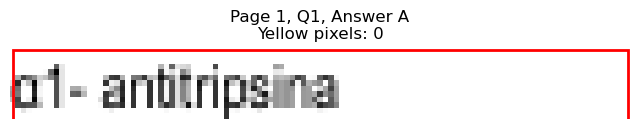

Page 1, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=133.5, y1=152.6
Page 1, Q1, B: Yellow pixels: 1232
Page 1, Q1, B: Total non-white pixels: 1624
Page 1, Q1, B: Yellow percentage: 75.9%


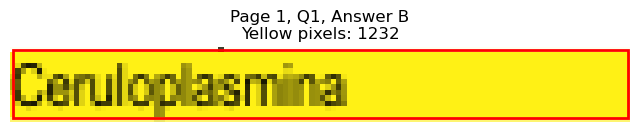

Page 1, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=363.2, y1=139.9
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 185
Page 1, Q1, C: Yellow percentage: 0.0%


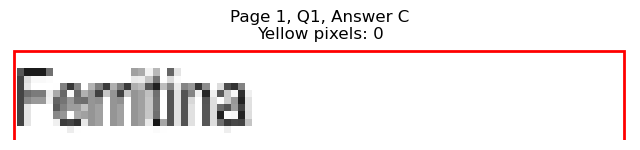

Page 1, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=362.1, y1=152.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 170
Page 1, Q1, D: Yellow percentage: 0.0%


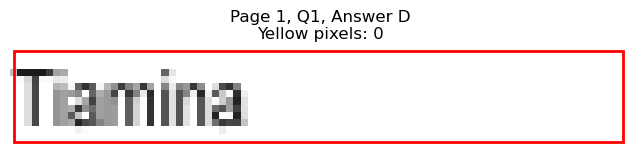


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=101.9, y1=190.4
Page 1, Q2, A: Yellow pixels: 84
Page 1, Q2, A: Total non-white pixels: 251
Page 1, Q2, A: Yellow percentage: 33.5%


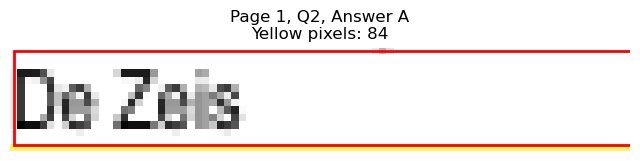

Page 1, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=101.4, y1=203.0
Page 1, Q2, B: Yellow pixels: 961
Page 1, Q2, B: Total non-white pixels: 1092
Page 1, Q2, B: Yellow percentage: 88.0%


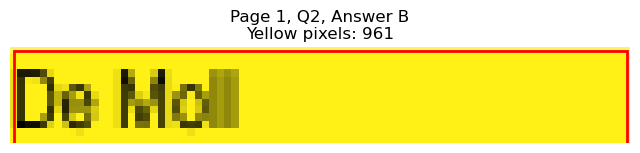

Page 1, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=351.7, y1=190.4
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 137
Page 1, Q2, C: Yellow percentage: 0.0%


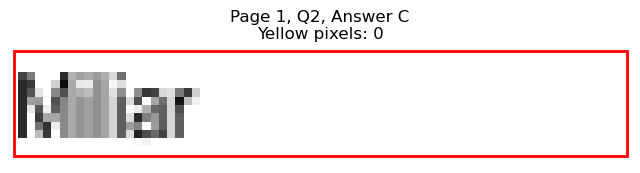

Page 1, Q2 - D: Detected box: x0=327.5, y0=606.9, x1=369.3, y1=619.6
Page 1, Q2, D: Yellow pixels: 923
Page 1, Q2, D: Total non-white pixels: 1302
Page 1, Q2, D: Yellow percentage: 70.9%


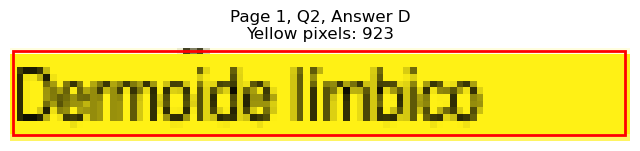


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=192.3, y1=266.1
Page 1, Q3, A: Yellow pixels: 1812
Page 1, Q3, A: Total non-white pixels: 2450
Page 1, Q3, A: Yellow percentage: 74.0%


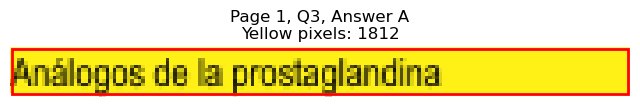

Page 1, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=198.6, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 883
Page 1, Q3, B: Yellow percentage: 0.0%


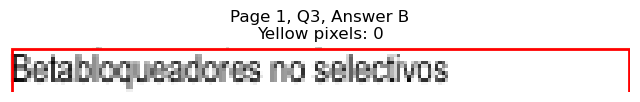

Page 1, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=480.1, y1=266.1
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 786
Page 1, Q3, C: Yellow percentage: 0.0%


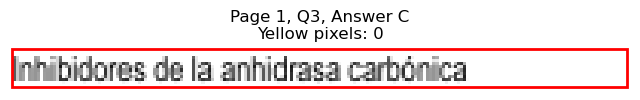

Page 1, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=462.4, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 734
Page 1, Q3, D: Yellow percentage: 0.0%


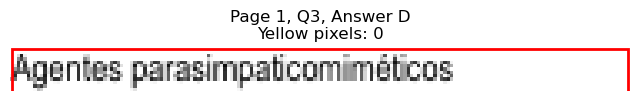


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=218.3, y1=316.7
Page 1, Q4, A: Yellow pixels: 2030
Page 1, Q4, A: Total non-white pixels: 2613
Page 1, Q4, A: Yellow percentage: 77.7%


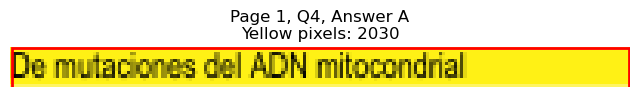

Page 1, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=214.2, y1=329.3
Page 1, Q4, B: Yellow pixels: 197
Page 1, Q4, B: Total non-white pixels: 909
Page 1, Q4, B: Yellow percentage: 21.7%


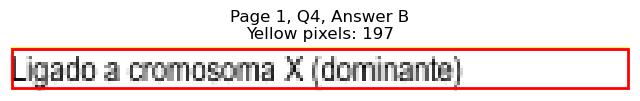

Page 1, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=440.9, y1=316.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 561
Page 1, Q4, C: Yellow percentage: 0.0%


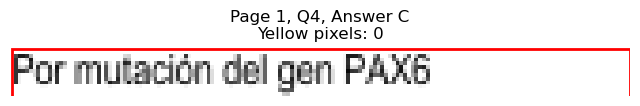

Page 1, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=464.9, y1=329.3
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 653
Page 1, Q4, D: Yellow percentage: 0.0%


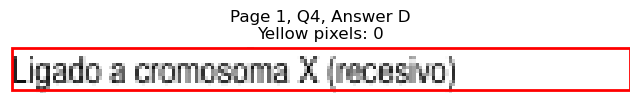


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=379.7, x1=142.0, y1=392.4
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 325
Page 1, Q5, A: Yellow percentage: 0.0%


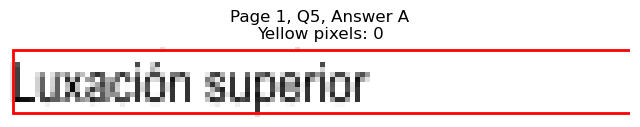

Page 1, Q5 - B: Detected box: x0=68.3, y0=392.3, x1=193.2, y1=405.0
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 616
Page 1, Q5, B: Yellow percentage: 0.0%


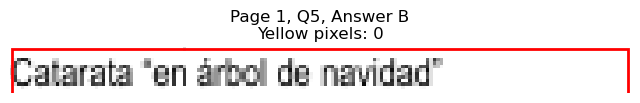

Page 1, Q5 - C: Detected box: x0=327.5, y0=379.7, x1=442.4, y1=392.4
Page 1, Q5, C: Yellow pixels: 166
Page 1, Q5, C: Total non-white pixels: 715
Page 1, Q5, C: Yellow percentage: 23.2%


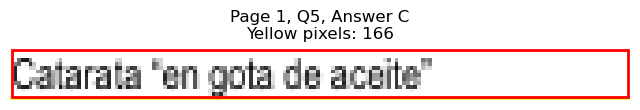

Page 1, Q5 - D: Detected box: x0=327.5, y0=392.3, x1=402.3, y1=405.0
Page 1, Q5, D: Yellow pixels: 1371
Page 1, Q5, D: Total non-white pixels: 1638
Page 1, Q5, D: Yellow percentage: 83.7%


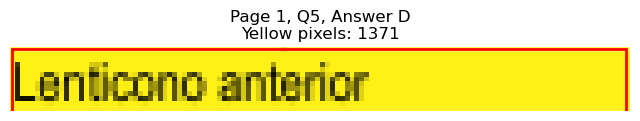


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=163.6, y1=455.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 488
Page 1, Q6, A: Yellow percentage: 0.0%


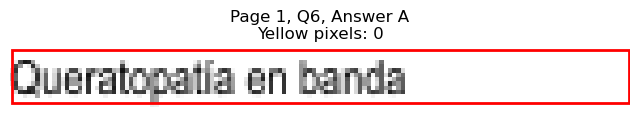

Page 1, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=160.1, y1=468.1
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 457
Page 1, Q6, B: Yellow percentage: 0.0%


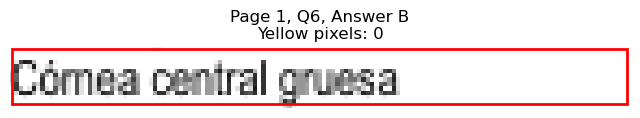

Page 1, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=390.8, y1=455.5
Page 1, Q6, C: Yellow pixels: 1243
Page 1, Q6, C: Total non-white pixels: 1596
Page 1, Q6, C: Yellow percentage: 77.9%


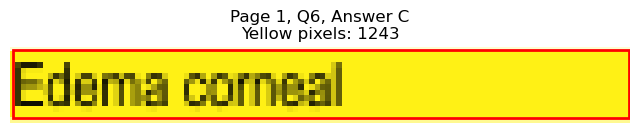

Page 1, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=368.7, y1=468.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 217
Page 1, Q6, D: Yellow percentage: 0.0%


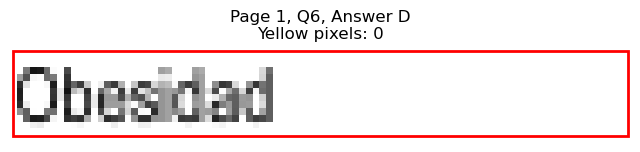


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=207.2, y1=518.6
Page 1, Q7, A: Yellow pixels: 1938
Page 1, Q7, A: Total non-white pixels: 2660
Page 1, Q7, A: Yellow percentage: 72.9%


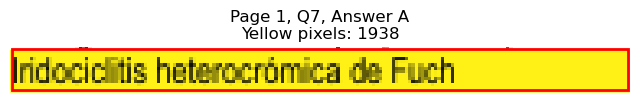

Page 1, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=238.4, y1=531.2
Page 1, Q7, B: Yellow pixels: 213
Page 1, Q7, B: Total non-white pixels: 1024
Page 1, Q7, B: Yellow percentage: 20.8%


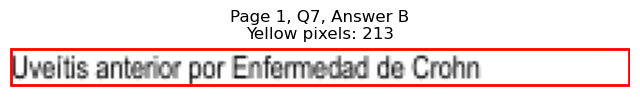

Page 1, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=453.9, y1=518.6
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 668
Page 1, Q7, C: Yellow percentage: 0.0%


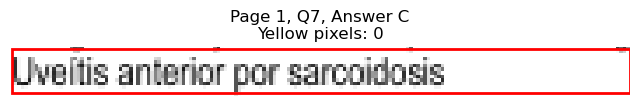

Page 1, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=404.8, y1=531.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 400
Page 1, Q7, D: Yellow percentage: 0.0%


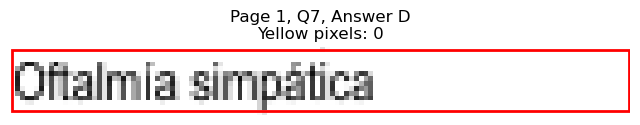


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=112.5, y1=569.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 225
Page 1, Q8, A: Yellow percentage: 0.0%


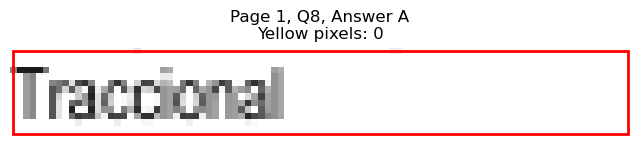

Page 1, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=127.5, y1=581.8
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 326
Page 1, Q8, B: Yellow percentage: 0.0%


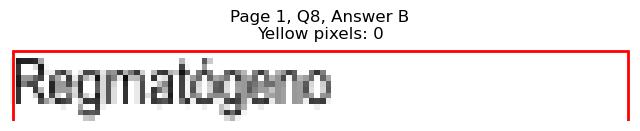

Page 1, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=383.2, y1=569.2
Page 1, Q8, C: Yellow pixels: 107
Page 1, Q8, C: Total non-white pixels: 406
Page 1, Q8, C: Yellow percentage: 26.4%


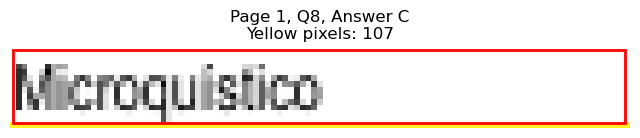

Page 1, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=369.7, y1=581.8
Page 1, Q8, D: Yellow pixels: 1044
Page 1, Q8, D: Total non-white pixels: 1209
Page 1, Q8, D: Yellow percentage: 86.4%


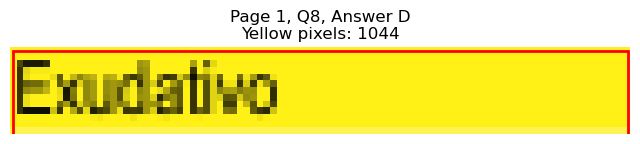


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=594.3, x1=141.5, y1=607.0
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 381
Page 1, Q9, A: Yellow percentage: 0.0%


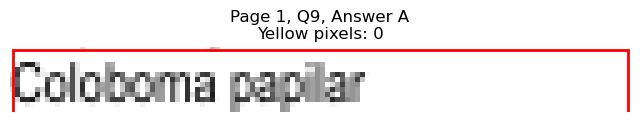

Page 1, Q9 - B: Detected box: x0=68.3, y0=606.9, x1=149.5, y1=619.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 412
Page 1, Q9, B: Yellow percentage: 0.0%


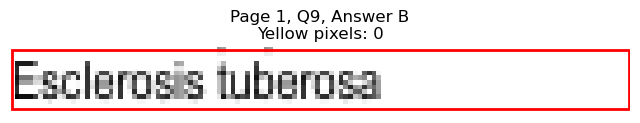

Page 1, Q9 - C: Detected box: x0=327.5, y0=594.3, x1=379.3, y1=607.0
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 348
Page 1, Q9, C: Yellow percentage: 0.0%


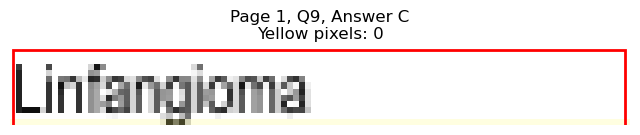

Page 1, Q9 - D: Detected box: x0=327.5, y0=606.9, x1=400.3, y1=619.6
Page 1, Q9, D: Yellow pixels: 1326
Page 1, Q9, D: Total non-white pixels: 1736
Page 1, Q9, D: Yellow percentage: 76.4%


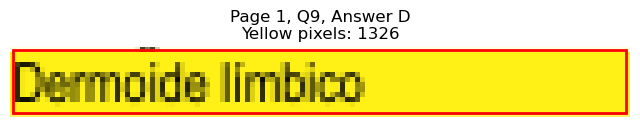


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=644.9, x1=125.4, y1=657.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 288
Page 1, Q10, A: Yellow percentage: 0.0%


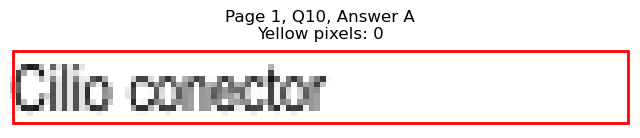

Page 1, Q10 - B: Detected box: x0=68.3, y0=657.5, x1=199.7, y1=670.1
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 670
Page 1, Q10, B: Yellow percentage: 0.0%


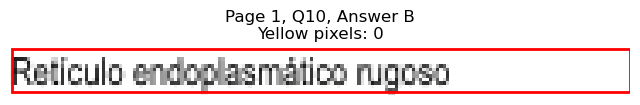

Page 1, Q10 - C: Detected box: x0=327.5, y0=644.9, x1=376.7, y1=657.5
Page 1, Q10, C: Yellow pixels: 1085
Page 1, Q10, C: Total non-white pixels: 1400
Page 1, Q10, C: Yellow percentage: 77.5%


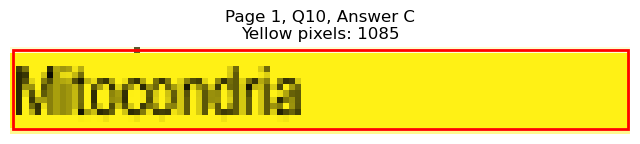

Page 1, Q10 - D: Detected box: x0=327.5, y0=657.5, x1=391.7, y1=670.1
Page 1, Q10, D: Yellow pixels: 115
Page 1, Q10, D: Total non-white pixels: 436
Page 1, Q10, D: Yellow percentage: 26.4%


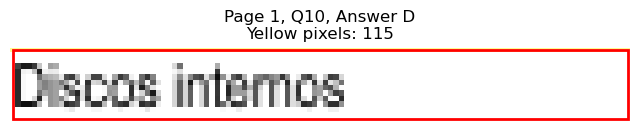


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=695.4, x1=126.0, y1=708.0
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 274
Page 1, Q11, A: Yellow percentage: 0.0%


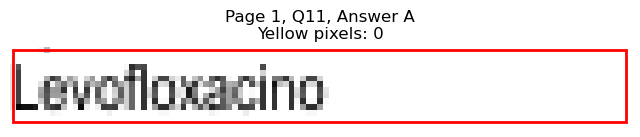

Page 1, Q11 - B: Detected box: x0=68.3, y0=708.0, x1=109.5, y1=720.6
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 230
Page 1, Q11, B: Yellow percentage: 0.0%


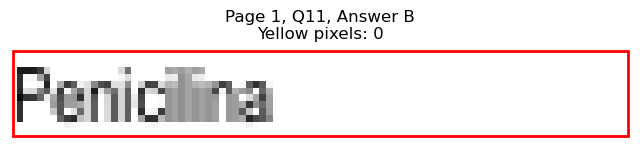

Page 1, Q11 - C: Detected box: x0=327.5, y0=695.4, x1=363.7, y1=708.0
Page 1, Q11, C: Yellow pixels: 87
Page 1, Q11, C: Total non-white pixels: 358
Page 1, Q11, C: Yellow percentage: 24.3%


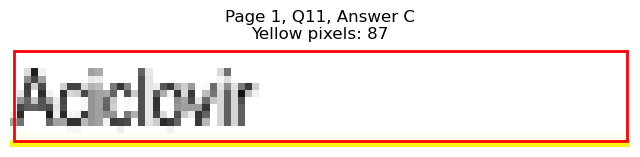

Page 1, Q11 - D: Detected box: x0=327.5, y0=708.0, x1=382.7, y1=720.6
Page 1, Q11, D: Yellow pixels: 1164
Page 1, Q11, D: Total non-white pixels: 1484
Page 1, Q11, D: Yellow percentage: 78.4%


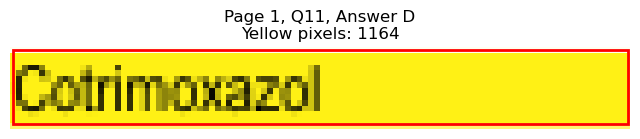


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 11 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=107.4, y1=127.3
Page 2, Q1, A: Yellow pixels: 90
Page 2, Q1, A: Total non-white pixels: 284
Page 2, Q1, A: Yellow percentage: 31.7%


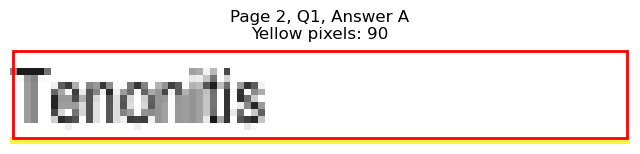

Page 2, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=117.5, y1=139.9
Page 2, Q1, B: Yellow pixels: 1082
Page 2, Q1, B: Total non-white pixels: 1300
Page 2, Q1, B: Yellow percentage: 83.2%


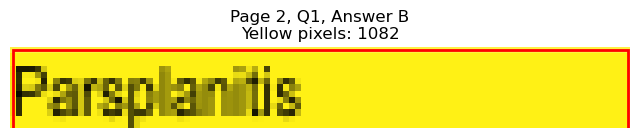

Page 2, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=371.7, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 250
Page 2, Q1, C: Yellow percentage: 0.0%


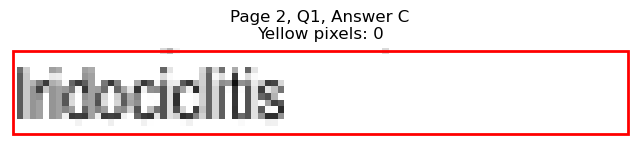

Page 2, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=403.7, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 404
Page 2, Q1, D: Yellow percentage: 0.0%


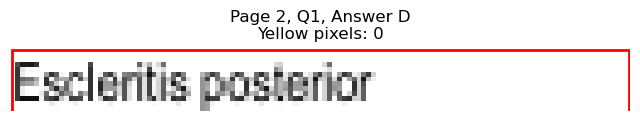


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=177.7, x1=185.7, y1=190.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 572
Page 2, Q2, A: Yellow percentage: 0.0%


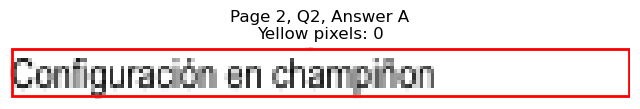

Page 2, Q2 - B: Detected box: x0=68.3, y0=190.3, x1=156.0, y1=203.0
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 445
Page 2, Q2, B: Yellow percentage: 0.0%


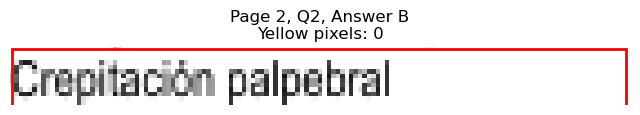

Page 2, Q2 - C: Detected box: x0=327.5, y0=177.7, x1=399.8, y1=190.4
Page 2, Q2, C: Yellow pixels: 1217
Page 2, Q2, C: Total non-white pixels: 1722
Page 2, Q2, C: Yellow percentage: 70.7%


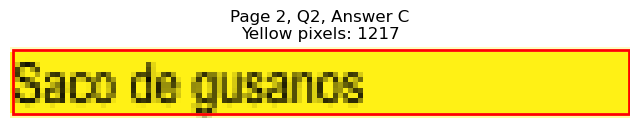

Page 2, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=412.7, y1=203.0
Page 2, Q2, D: Yellow pixels: 2
Page 2, Q2, D: Total non-white pixels: 592
Page 2, Q2, D: Yellow percentage: 0.3%


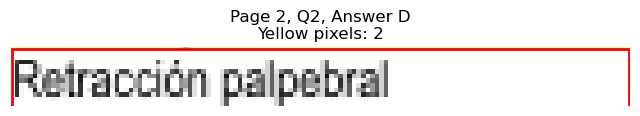


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=230.8, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 845
Page 2, Q3, A: Yellow percentage: 0.0%


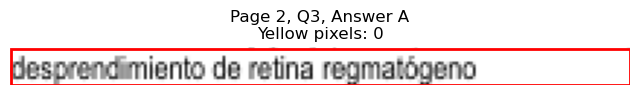

Page 2, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=216.3, y1=253.5
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 756
Page 2, Q3, B: Yellow percentage: 0.0%


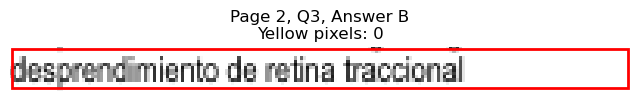

Page 2, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=464.0, y1=240.9
Page 2, Q3, C: Yellow pixels: 1897
Page 2, Q3, C: Total non-white pixels: 2431
Page 2, Q3, C: Yellow percentage: 78.0%


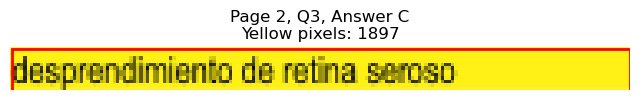

Page 2, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=380.2, y1=253.5
Page 2, Q3, D: Yellow pixels: 103
Page 2, Q3, D: Total non-white pixels: 394
Page 2, Q3, D: Yellow percentage: 26.1%


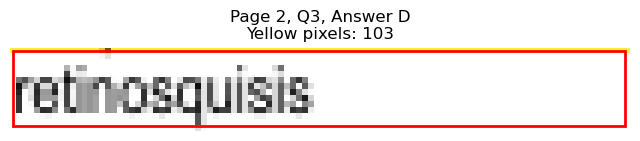


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=278.8, x1=111.4, y1=291.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 225
Page 2, Q4, A: Yellow percentage: 0.0%


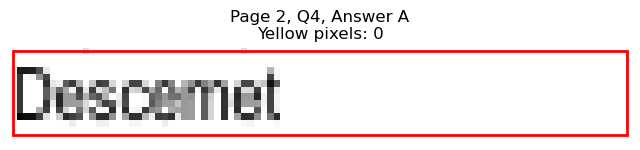

Page 2, Q4 - B: Detected box: x0=68.3, y0=291.4, x1=105.9, y1=304.1
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 175
Page 2, Q4, B: Yellow percentage: 0.0%


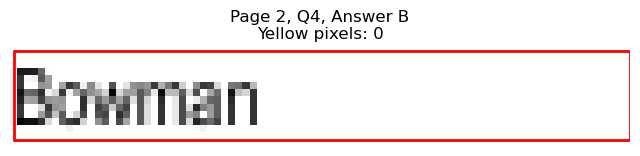

Page 2, Q4 - C: Detected box: x0=327.5, y0=278.8, x1=363.7, y1=291.5
Page 2, Q4, C: Yellow pixels: 999
Page 2, Q4, C: Total non-white pixels: 1218
Page 2, Q4, C: Yellow percentage: 82.0%


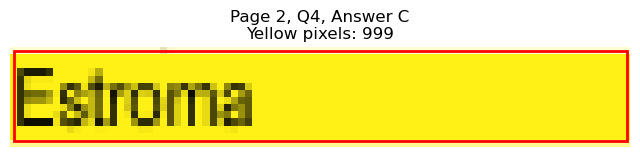

Page 2, Q4 - D: Detected box: x0=327.5, y0=291.4, x1=367.6, y1=304.1
Page 2, Q4, D: Yellow pixels: 91
Page 2, Q4, D: Total non-white pixels: 297
Page 2, Q4, D: Yellow percentage: 30.6%


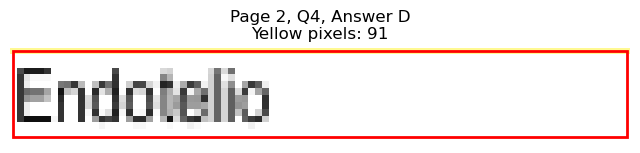


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=109.9, y1=341.9
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 198
Page 2, Q5, A: Yellow percentage: 0.0%


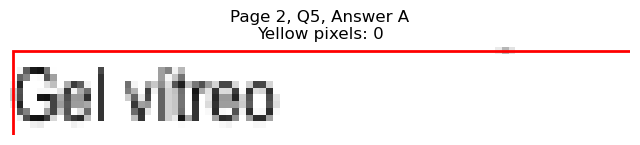

Page 2, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=154.6, y1=354.6
Page 2, Q5, B: Yellow pixels: 1439
Page 2, Q5, B: Total non-white pixels: 1918
Page 2, Q5, B: Yellow percentage: 75.0%


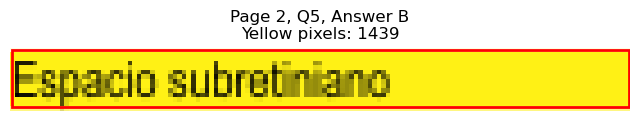

Page 2, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=395.2, y1=341.9
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 324
Page 2, Q5, C: Yellow percentage: 0.0%


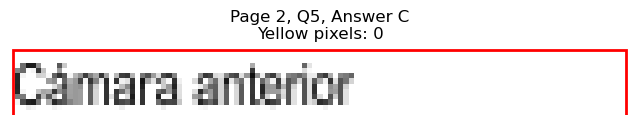

Page 2, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=419.3, y1=354.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 486
Page 2, Q5, D: Yellow percentage: 0.0%


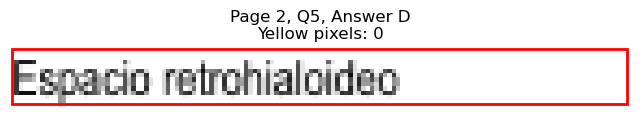


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=363.8, y1=392.4
Page 2, Q6, A: Yellow pixels: 346
Page 2, Q6, A: Total non-white pixels: 1828
Page 2, Q6, A: Yellow percentage: 18.9%


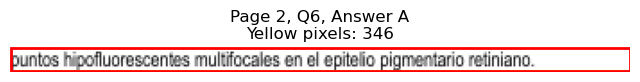

Page 2, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=351.2, y1=405.0
Page 2, Q6, B: Yellow pixels: 3220
Page 2, Q6, B: Total non-white pixels: 4342
Page 2, Q6, B: Yellow percentage: 74.2%


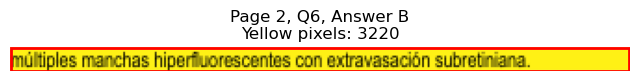

Page 2, Q6 - C: Detected box: x0=68.8, y0=404.9, x1=292.5, y1=417.6
Page 2, Q6, C: Yellow pixels: 273
Page 2, Q6, C: Total non-white pixels: 1393
Page 2, Q6, C: Yellow percentage: 19.6%


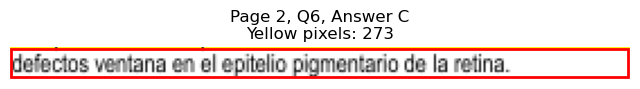

Page 2, Q6 - D: Detected box: x0=68.8, y0=417.6, x1=210.8, y1=430.3
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 670
Page 2, Q6, D: Yellow percentage: 0.0%


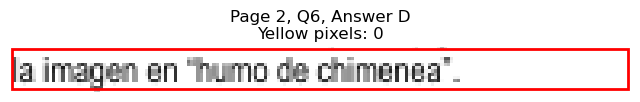


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=455.5, x1=146.5, y1=468.1
Page 2, Q7, A: Yellow pixels: 1350
Page 2, Q7, A: Total non-white pixels: 1806
Page 2, Q7, A: Yellow percentage: 74.8%


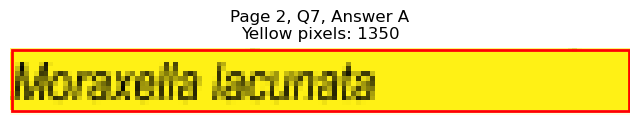

Page 2, Q7 - B: Detected box: x0=68.3, y0=468.1, x1=150.0, y1=480.7
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 537
Page 2, Q7, B: Yellow percentage: 0.0%


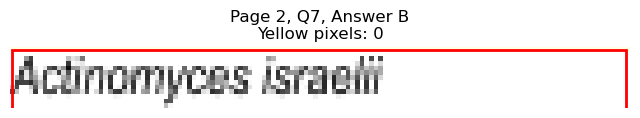

Page 2, Q7 - C: Detected box: x0=327.5, y0=455.5, x1=421.9, y1=468.1
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 487
Page 2, Q7, C: Yellow percentage: 0.0%


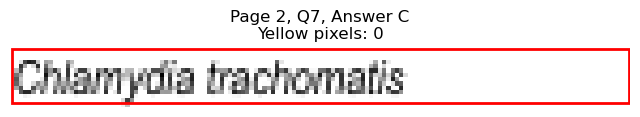

Page 2, Q7 - D: Detected box: x0=327.5, y0=468.1, x1=412.3, y1=480.7
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 425
Page 2, Q7, D: Yellow percentage: 0.0%


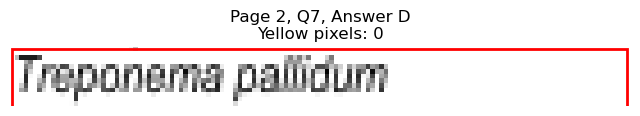


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=200.3, y1=569.2
Page 2, Q8, A: Yellow pixels: 183
Page 2, Q8, A: Total non-white pixels: 866
Page 2, Q8, A: Yellow percentage: 21.1%


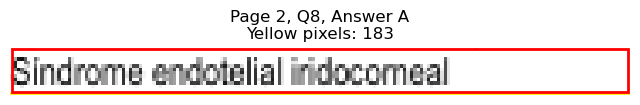

Page 2, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=194.7, y1=581.8
Page 2, Q8, B: Yellow pixels: 1791
Page 2, Q8, B: Total non-white pixels: 2301
Page 2, Q8, B: Yellow percentage: 77.8%


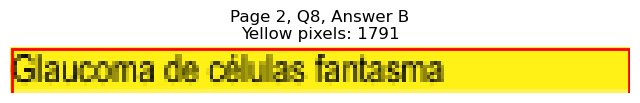

Page 2, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=415.9, y1=569.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 430
Page 2, Q8, C: Yellow percentage: 0.0%


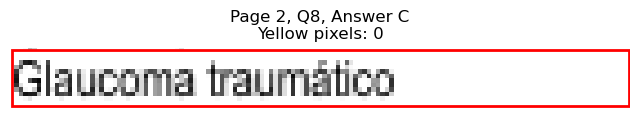

Page 2, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=494.0, y1=581.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 813
Page 2, Q8, D: Yellow percentage: 0.0%


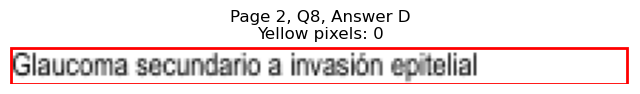


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=514.7, y1=619.6
Page 2, Q9, A: Yellow pixels: 4530
Page 2, Q9, A: Total non-white pixels: 6621
Page 2, Q9, A: Yellow percentage: 68.4%


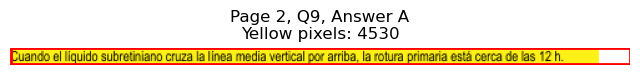

Page 2, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=514.7, y1=632.3
Page 2, Q9, B: Yellow pixels: 472
Page 2, Q9, B: Total non-white pixels: 2630
Page 2, Q9, B: Yellow percentage: 17.9%


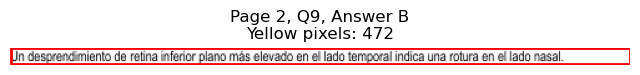

Page 2, Q9 - C: Detected box: x0=68.8, y0=632.2, x1=458.5, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 1878
Page 2, Q9, C: Yellow percentage: 0.0%


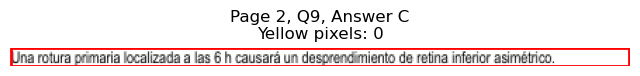

Page 2, Q9 - D: Detected box: x0=68.8, y0=644.9, x1=528.7, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 2232
Page 2, Q9, D: Yellow percentage: 0.0%


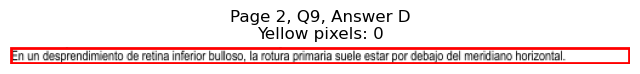


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=682.7, x1=150.5, y1=695.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 448
Page 2, Q10, A: Yellow percentage: 0.0%


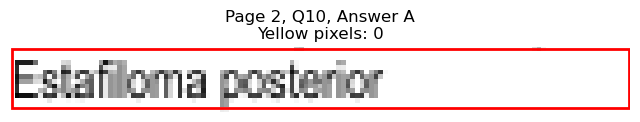

Page 2, Q10 - B: Detected box: x0=68.3, y0=695.4, x1=197.2, y1=708.0
Page 2, Q10, B: Yellow pixels: 1864
Page 2, Q10, B: Total non-white pixels: 2341
Page 2, Q10, B: Yellow percentage: 79.6%


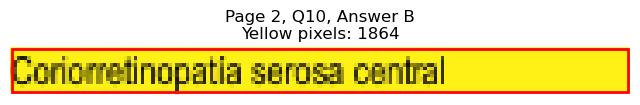

Page 2, Q10 - C: Detected box: x0=327.5, y0=682.7, x1=382.3, y1=695.3
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 269
Page 2, Q10, C: Yellow percentage: 0.0%


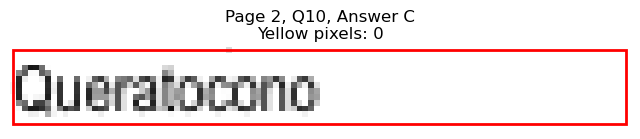

Page 2, Q10 - D: Detected box: x0=327.5, y0=695.4, x1=384.7, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 324
Page 2, Q10, D: Yellow percentage: 0.0%


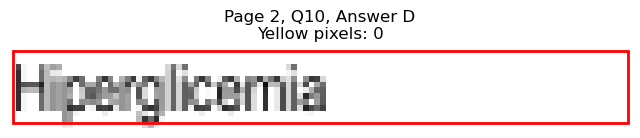


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)




Page 2, Q11 - A: Detected box: x0=68.3, y0=733.2, x1=176.2, y1=745.8
Page 2, Q11, A: Yellow pixels: 0
Page 2, Q11, A: Total non-white pixels: 528
Page 2, Q11, A: Yellow percentage: 0.0%


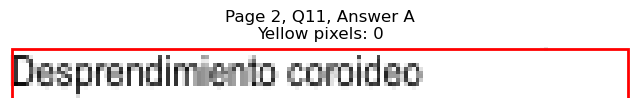

Page 2, Q11 - B: Detected box: x0=68.3, y0=745.8, x1=155.5, y1=758.4
Page 2, Q11, B: Yellow pixels: 0
Page 2, Q11, B: Total non-white pixels: 421
Page 2, Q11, B: Yellow percentage: 0.0%


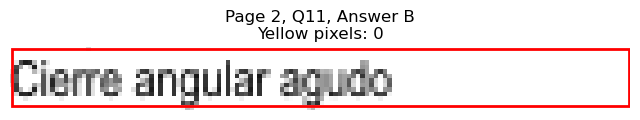

Page 2, Q11 - C: Detected box: x0=327.5, y0=733.2, x1=403.3, y1=745.8
Page 2, Q11, C: Yellow pixels: 0
Page 2, Q11, C: Total non-white pixels: 534
Page 2, Q11, C: Yellow percentage: 0.0%


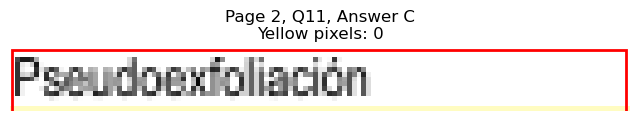

Page 2, Q11 - D: Detected box: x0=327.5, y0=745.8, x1=406.3, y1=758.4
Page 2, Q11, D: Yellow pixels: 1376
Page 2, Q11, D: Total non-white pixels: 1820
Page 2, Q11, D: Yellow percentage: 75.6%


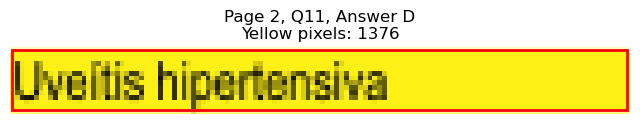


Page 2, Q11 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=182.7, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 585
Page 3, Q1, A: Yellow percentage: 0.0%


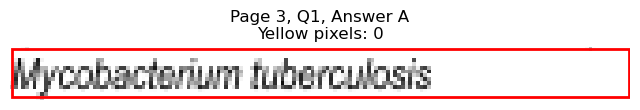

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=153.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 417
Page 3, Q1, B: Yellow percentage: 0.0%


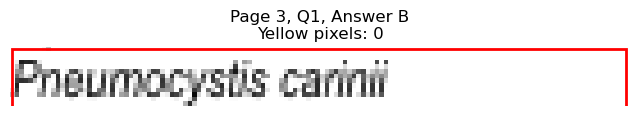

Page 3, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=391.3, y1=127.3
Page 3, Q1, C: Yellow pixels: 1157
Page 3, Q1, C: Total non-white pixels: 1610
Page 3, Q1, C: Yellow percentage: 71.9%


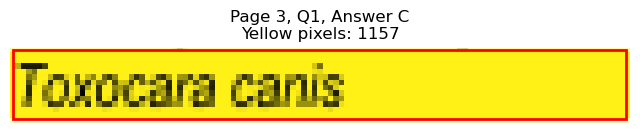

Page 3, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=434.8, y1=139.9
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 681
Page 3, Q1, D: Yellow percentage: 0.0%


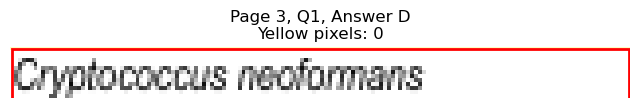


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=382.3, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 1602
Page 3, Q2, A: Yellow percentage: 0.0%


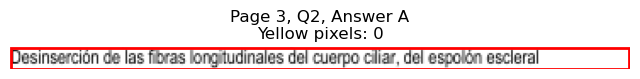

Page 3, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=264.9, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 917
Page 3, Q2, B: Yellow percentage: 0.0%


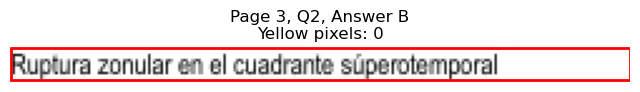

Page 3, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=303.0, y1=203.0
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 1424
Page 3, Q2, C: Yellow percentage: 0.0%


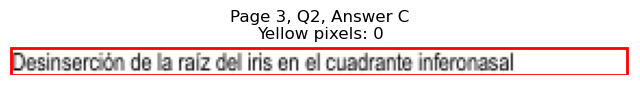

Page 3, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=350.7, y1=215.6
Page 3, Q2, D: Yellow pixels: 3221
Page 3, Q2, D: Total non-white pixels: 4662
Page 3, Q2, D: Yellow percentage: 69.1%


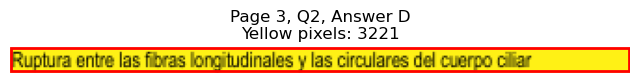


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=437.6, y1=253.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 1838
Page 3, Q3, A: Yellow percentage: 0.0%


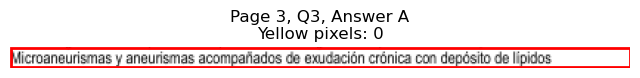

Page 3, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=533.3, y1=266.1
Page 3, Q3, B: Yellow pixels: 472
Page 3, Q3, B: Total non-white pixels: 2793
Page 3, Q3, B: Yellow percentage: 16.9%


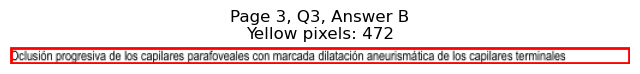

Page 3, Q3 - C: Detected box: x0=68.8, y0=266.1, x1=499.2, y1=278.7
Page 3, Q3, C: Yellow pixels: 4428
Page 3, Q3, C: Total non-white pixels: 6149
Page 3, Q3, C: Yellow percentage: 72.0%


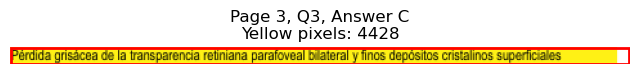

Page 3, Q3 - D: Detected box: x0=68.8, y0=278.8, x1=540.9, y1=291.5
Page 3, Q3, D: Yellow pixels: 469
Page 3, Q3, D: Total non-white pixels: 2779
Page 3, Q3, D: Yellow percentage: 16.9%


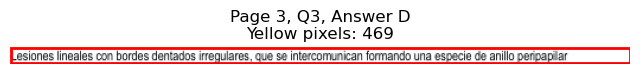


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=316.6, x1=103.9, y1=329.3
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 192
Page 3, Q4, A: Yellow percentage: 0.0%


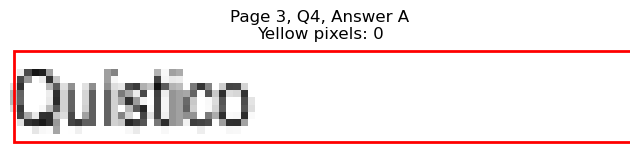

Page 3, Q4 - B: Detected box: x0=68.3, y0=329.2, x1=121.5, y1=341.9
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 286
Page 3, Q4, B: Yellow percentage: 0.0%


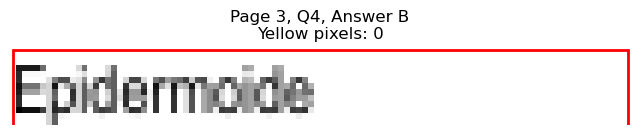

Page 3, Q4 - C: Detected box: x0=327.5, y0=316.6, x1=372.7, y1=329.3
Page 3, Q4, C: Yellow pixels: 96
Page 3, Q4, C: Total non-white pixels: 317
Page 3, Q4, C: Yellow percentage: 30.3%


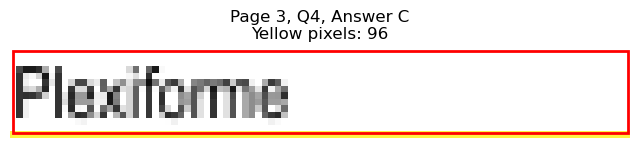

Page 3, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=377.7, y1=341.9
Page 3, Q4, D: Yellow pixels: 1128
Page 3, Q4, D: Total non-white pixels: 1313
Page 3, Q4, D: Yellow percentage: 85.9%


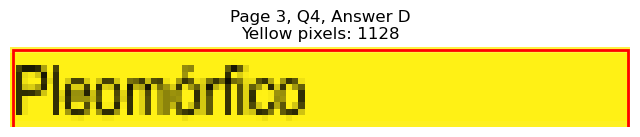


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=171.1, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 515
Page 3, Q5, A: Yellow percentage: 0.0%


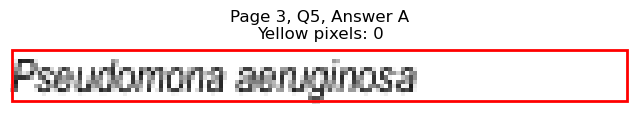

Page 3, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=167.1, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 497
Page 3, Q5, B: Yellow percentage: 0.0%


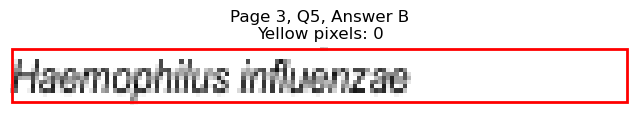

Page 3, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=445.9, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 606
Page 3, Q5, C: Yellow percentage: 0.0%


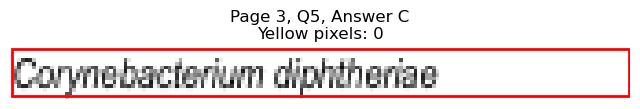

Page 3, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=429.3, y1=430.3
Page 3, Q5, D: Yellow pixels: 1437
Page 3, Q5, D: Total non-white pixels: 2142
Page 3, Q5, D: Yellow percentage: 67.1%


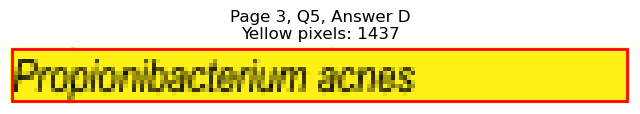


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=480.8, x1=169.1, y1=493.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 509
Page 3, Q6, A: Yellow percentage: 0.0%


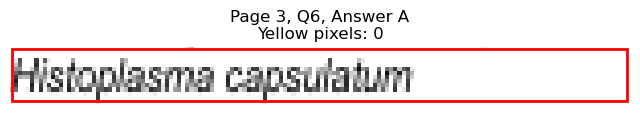

Page 3, Q6 - B: Detected box: x0=68.3, y0=493.4, x1=146.5, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 398
Page 3, Q6, B: Yellow percentage: 0.0%


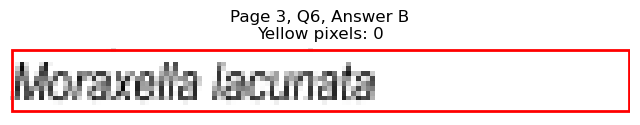

Page 3, Q6 - C: Detected box: x0=327.5, y0=480.8, x1=409.9, y1=493.4
Page 3, Q6, C: Yellow pixels: 1252
Page 3, Q6, C: Total non-white pixels: 1862
Page 3, Q6, C: Yellow percentage: 67.2%


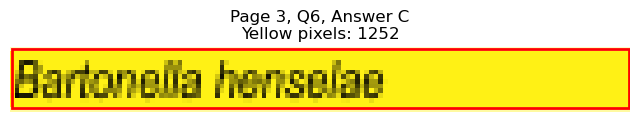

Page 3, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=405.4, y1=506.0
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 535
Page 3, Q6, D: Yellow percentage: 0.0%


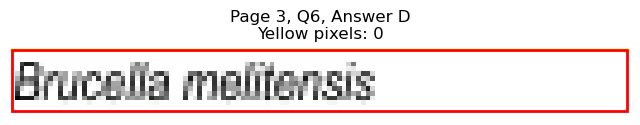


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=531.2, x1=109.5, y1=543.8
Page 3, Q7, A: Yellow pixels: 1033
Page 3, Q7, A: Total non-white pixels: 1196
Page 3, Q7, A: Yellow percentage: 86.4%


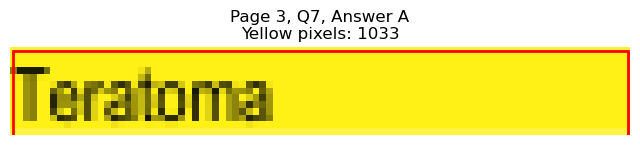

Page 3, Q7 - B: Detected box: x0=68.3, y0=543.8, x1=118.0, y1=556.4
Page 3, Q7, B: Yellow pixels: 100
Page 3, Q7, B: Total non-white pixels: 341
Page 3, Q7, B: Yellow percentage: 29.3%


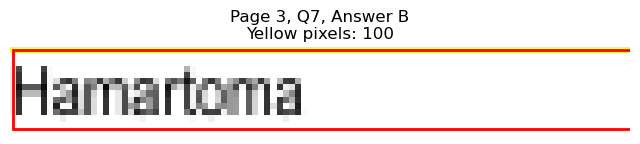

Page 3, Q7 - C: Detected box: x0=327.5, y0=531.2, x1=371.2, y1=543.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 226
Page 3, Q7, C: Yellow percentage: 0.0%


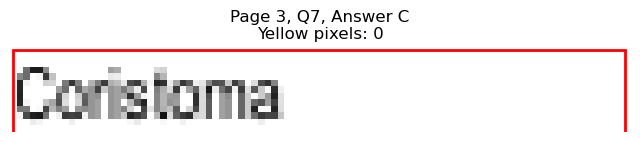

Page 3, Q7 - D: Detected box: x0=327.5, y0=543.8, x1=379.1, y1=556.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 284
Page 3, Q7, D: Yellow percentage: 0.0%


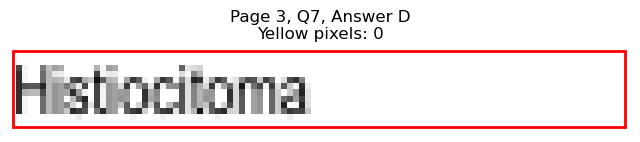


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=594.3, x1=109.0, y1=607.0
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 196
Page 3, Q8, A: Yellow percentage: 0.0%


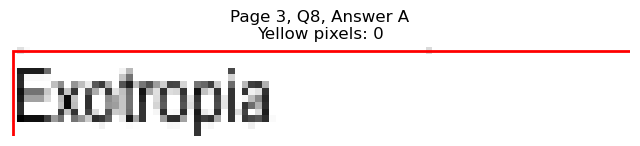

Page 3, Q8 - B: Detected box: x0=68.3, y0=606.9, x1=95.4, y1=619.6
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 130
Page 3, Q8, B: Yellow percentage: 0.0%


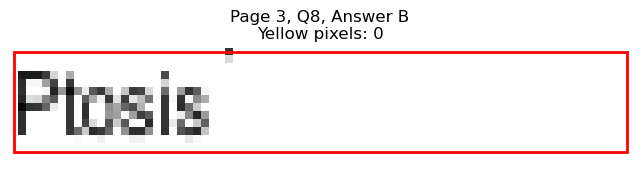

Page 3, Q8 - C: Detected box: x0=327.5, y0=594.3, x1=371.2, y1=607.0
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 329
Page 3, Q8, C: Yellow percentage: 0.0%


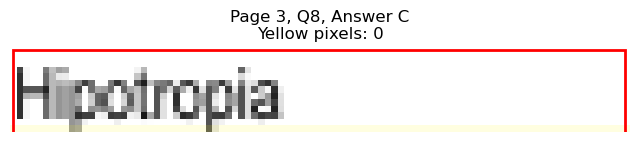

Page 3, Q8 - D: Detected box: x0=327.5, y0=606.9, x1=365.7, y1=619.6
Page 3, Q8, D: Yellow pixels: 984
Page 3, Q8, D: Total non-white pixels: 1246
Page 3, Q8, D: Yellow percentage: 79.0%


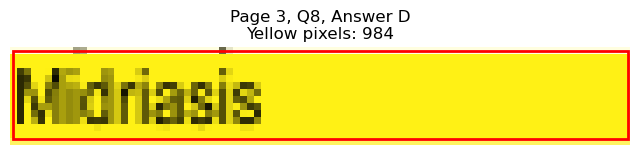


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=644.9, x1=141.5, y1=657.5
Page 3, Q9, A: Yellow pixels: 1311
Page 3, Q9, A: Total non-white pixels: 1736
Page 3, Q9, A: Yellow percentage: 75.5%


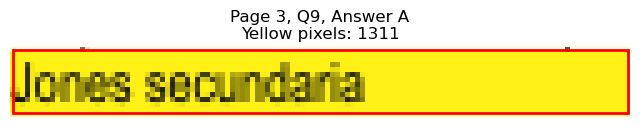

Page 3, Q9 - B: Detected box: x0=68.3, y0=657.5, x1=130.0, y1=670.1
Page 3, Q9, B: Yellow pixels: 112
Page 3, Q9, B: Total non-white pixels: 404
Page 3, Q9, B: Yellow percentage: 27.7%


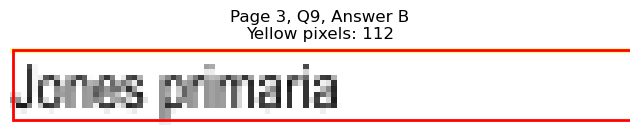

Page 3, Q9 - C: Detected box: x0=327.5, y0=644.9, x1=459.5, y1=657.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 695
Page 3, Q9, C: Yellow percentage: 0.0%


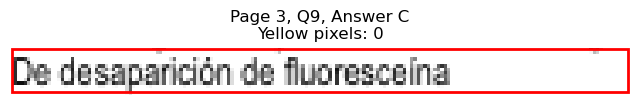

Page 3, Q9 - D: Detected box: x0=327.5, y0=657.5, x1=413.8, y1=670.1
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 444
Page 3, Q9, D: Yellow percentage: 0.0%


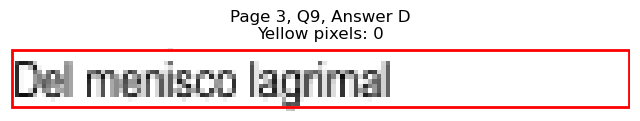


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=307.0, y1=708.0
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 1106
Page 3, Q10, A: Yellow percentage: 0.0%


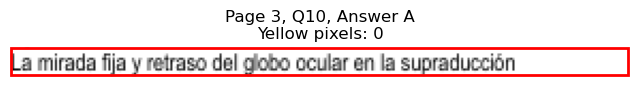

Page 3, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=396.8, y1=720.6
Page 3, Q10, B: Yellow pixels: 0
Page 3, Q10, B: Total non-white pixels: 1645
Page 3, Q10, B: Yellow percentage: 0.0%


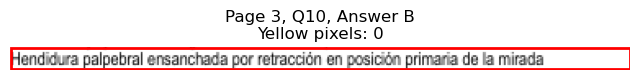

Page 3, Q10 - C: Detected box: x0=68.8, y0=720.6, x1=199.6, y1=733.2
Page 3, Q10, C: Yellow pixels: 182
Page 3, Q10, C: Total non-white pixels: 818
Page 3, Q10, C: Yellow percentage: 22.2%


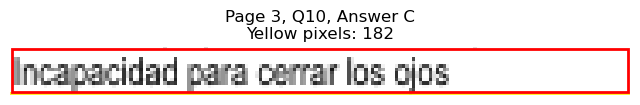

Page 3, Q10 - D: Detected box: x0=68.8, y0=733.2, x1=331.7, y1=745.8
Page 3, Q10, D: Yellow pixels: 3053
Page 3, Q10, D: Total non-white pixels: 4082
Page 3, Q10, D: Yellow percentage: 74.8%


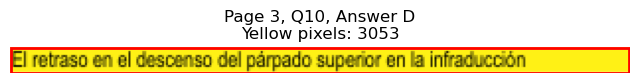


Page 3, Q10 - Selected Answer: D (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=121.5, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 292
Page 4, Q1, A: Yellow percentage: 0.0%


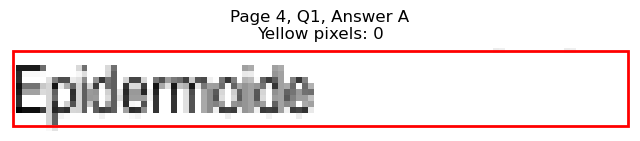

Page 4, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=154.1, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 447
Page 4, Q1, B: Yellow percentage: 0.0%


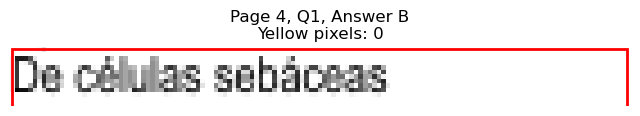

Page 4, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=377.2, y1=102.1
Page 4, Q1, C: Yellow pixels: 1125
Page 4, Q1, C: Total non-white pixels: 1414
Page 4, Q1, C: Yellow percentage: 79.6%


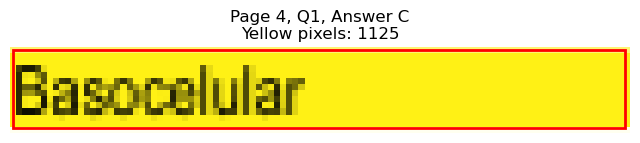

Page 4, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=414.3, y1=114.7
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 589
Page 4, Q1, D: Yellow percentage: 0.0%


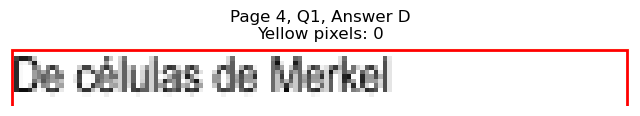


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=137.5, y1=152.6
Page 4, Q2, A: Yellow pixels: 120
Page 4, Q2, A: Total non-white pixels: 477
Page 4, Q2, A: Yellow percentage: 25.2%


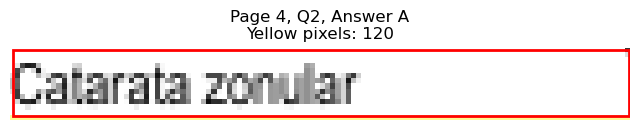

Page 4, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=161.1, y1=165.2
Page 4, Q2, B: Yellow pixels: 1520
Page 4, Q2, B: Total non-white pixels: 2016
Page 4, Q2, B: Yellow percentage: 75.4%


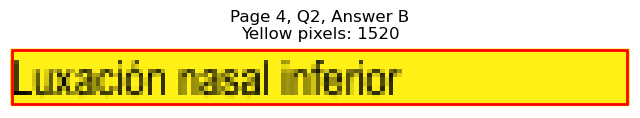

Page 4, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=401.2, y1=152.6
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 374
Page 4, Q2, C: Yellow percentage: 0.0%


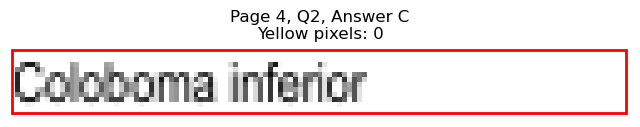

Page 4, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=406.7, y1=165.2
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 388
Page 4, Q2, D: Yellow percentage: 0.0%


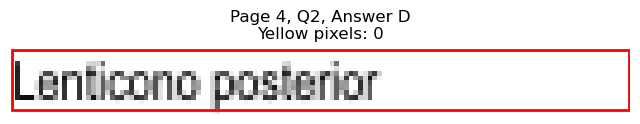


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=112.0, y1=203.0
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 221
Page 4, Q3, A: Yellow percentage: 0.0%


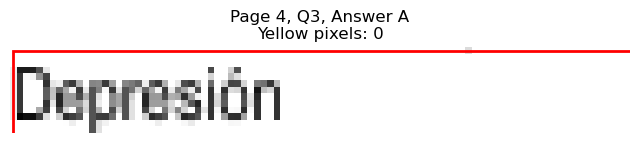

Page 4, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=118.0, y1=215.6
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 242
Page 4, Q3, B: Yellow percentage: 0.0%


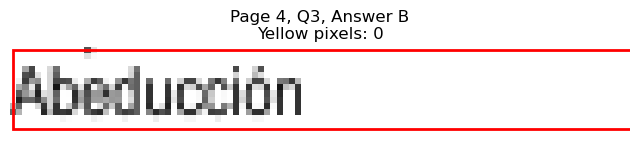

Page 4, Q3 - C: Detected box: x0=327.5, y0=190.3, x1=364.6, y1=203.0
Page 4, Q3, C: Yellow pixels: 988
Page 4, Q3, C: Total non-white pixels: 1144
Page 4, Q3, C: Yellow percentage: 86.4%


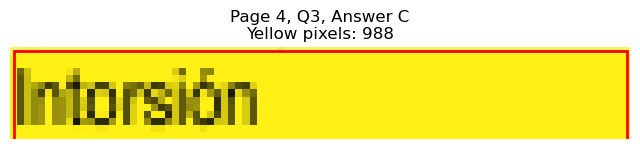

Page 4, Q3 - D: Detected box: x0=327.5, y0=202.9, x1=367.6, y1=215.6
Page 4, Q3, D: Yellow pixels: 91
Page 4, Q3, D: Total non-white pixels: 293
Page 4, Q3, D: Yellow percentage: 31.1%


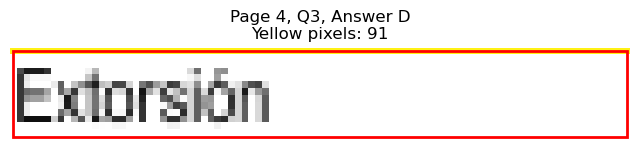


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=240.9, x1=377.7, y1=253.5
Page 4, Q4, A: Yellow pixels: 360
Page 4, Q4, A: Total non-white pixels: 1882
Page 4, Q4, A: Yellow percentage: 19.1%


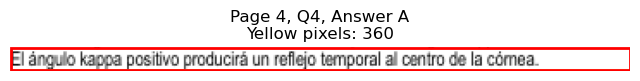

Page 4, Q4 - B: Detected box: x0=68.3, y0=253.5, x1=339.7, y1=266.1
Page 4, Q4, B: Yellow pixels: 3178
Page 4, Q4, B: Total non-white pixels: 4508
Page 4, Q4, B: Yellow percentage: 70.5%


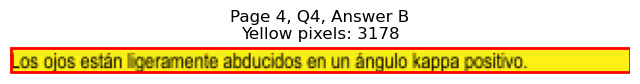

Page 4, Q4 - C: Detected box: x0=68.8, y0=266.1, x1=316.6, y1=278.7
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 1555
Page 4, Q4, C: Yellow percentage: 0.0%


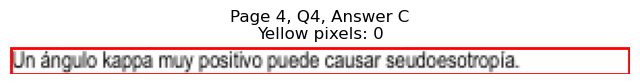

Page 4, Q4 - D: Detected box: x0=68.8, y0=278.8, x1=292.0, y1=291.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 1117
Page 4, Q4, D: Yellow percentage: 0.0%


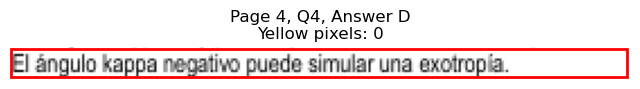


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=329.2, x1=117.5, y1=341.9
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 244
Page 4, Q5, A: Yellow percentage: 0.0%


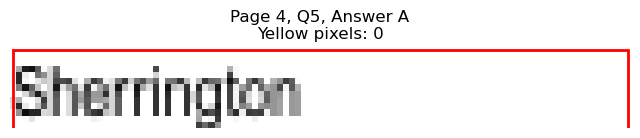

Page 4, Q5 - B: Detected box: x0=68.3, y0=341.9, x1=111.4, y1=354.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 230
Page 4, Q5, B: Yellow percentage: 0.0%


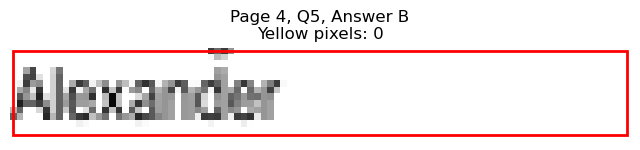

Page 4, Q5 - C: Detected box: x0=327.5, y0=329.2, x1=356.6, y1=341.9
Page 4, Q5, C: Yellow pixels: 905
Page 4, Q5, C: Total non-white pixels: 1040
Page 4, Q5, C: Yellow percentage: 87.0%


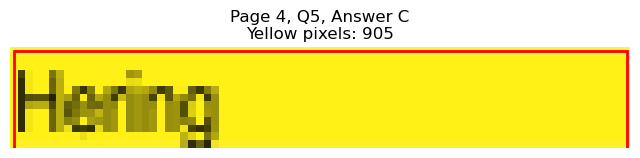

Page 4, Q5 - D: Detected box: x0=327.5, y0=341.9, x1=362.1, y1=354.6
Page 4, Q5, D: Yellow pixels: 82
Page 4, Q5, D: Total non-white pixels: 245
Page 4, Q5, D: Yellow percentage: 33.5%


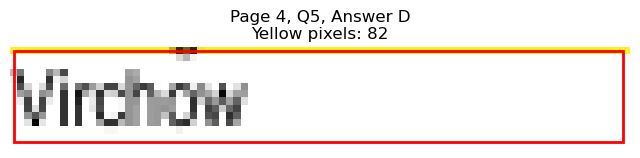


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=379.7, x1=150.0, y1=392.4
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 409
Page 4, Q6, A: Yellow percentage: 0.0%


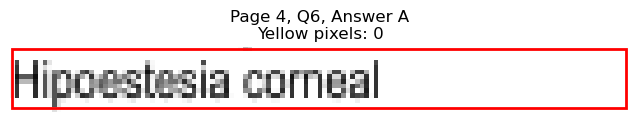

Page 4, Q6 - B: Detected box: x0=68.3, y0=392.3, x1=157.6, y1=405.0
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 433
Page 4, Q6, B: Yellow percentage: 0.0%


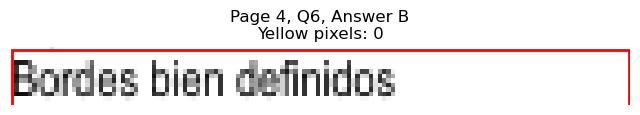

Page 4, Q6 - C: Detected box: x0=327.5, y0=379.7, x1=397.3, y1=392.4
Page 4, Q6, C: Yellow pixels: 1168
Page 4, Q6, C: Total non-white pixels: 1694
Page 4, Q6, C: Yellow percentage: 68.9%


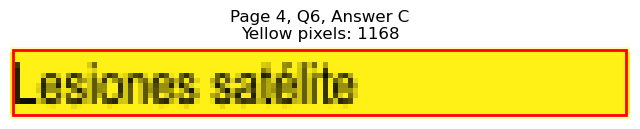

Page 4, Q6 - D: Detected box: x0=327.5, y0=392.3, x1=379.7, y1=405.0
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 389
Page 4, Q6, D: Yellow percentage: 0.0%


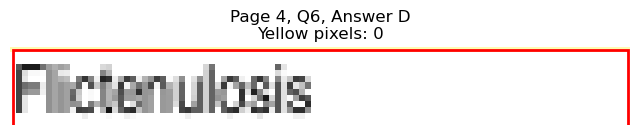


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=430.2, x1=109.0, y1=442.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 199
Page 4, Q7, A: Yellow percentage: 0.0%


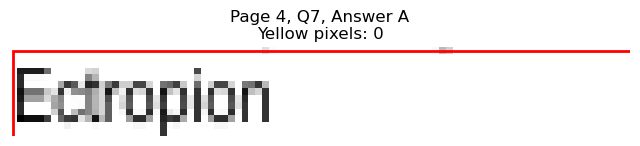

Page 4, Q7 - B: Detected box: x0=68.3, y0=442.8, x1=109.5, y1=455.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 212
Page 4, Q7, B: Yellow percentage: 0.0%


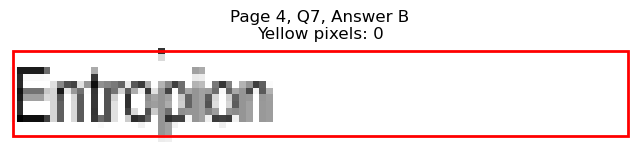

Page 4, Q7 - C: Detected box: x0=327.5, y0=430.2, x1=379.3, y1=442.9
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 349
Page 4, Q7, C: Yellow percentage: 0.0%


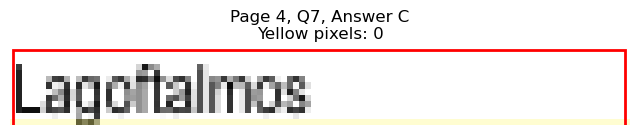

Page 4, Q7 - D: Detected box: x0=327.5, y0=442.8, x1=354.7, y1=455.5
Page 4, Q7, D: Yellow pixels: 918
Page 4, Q7, D: Total non-white pixels: 1092
Page 4, Q7, D: Yellow percentage: 84.1%


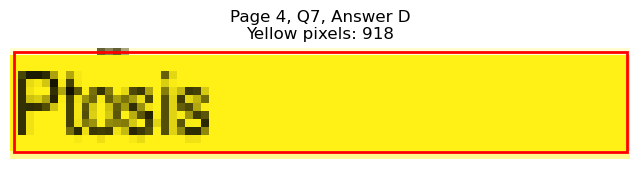


Page 4, Q7 - Selected Answer: D (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=480.8, x1=123.5, y1=493.4
Page 4, Q8, A: Yellow pixels: 106
Page 4, Q8, A: Total non-white pixels: 383
Page 4, Q8, A: Yellow percentage: 27.7%


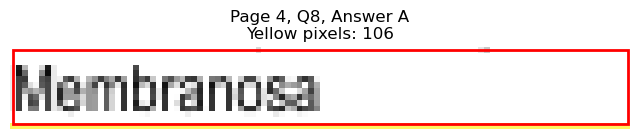

Page 4, Q8 - B: Detected box: x0=68.3, y0=493.4, x1=132.5, y1=506.0
Page 4, Q8, B: Yellow pixels: 1252
Page 4, Q8, B: Total non-white pixels: 1495
Page 4, Q8, B: Yellow percentage: 83.7%


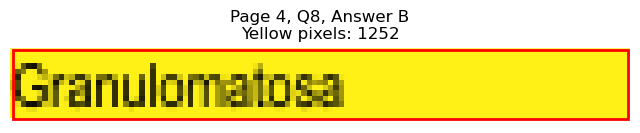

Page 4, Q8 - C: Detected box: x0=327.5, y0=480.8, x1=390.3, y1=493.4
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 336
Page 4, Q8, C: Yellow percentage: 0.0%


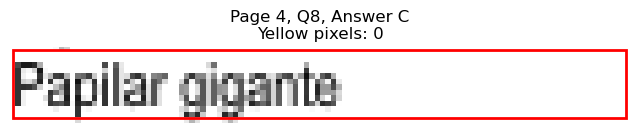

Page 4, Q8 - D: Detected box: x0=327.5, y0=493.4, x1=359.7, y1=506.0
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 149
Page 4, Q8, D: Yellow percentage: 0.0%


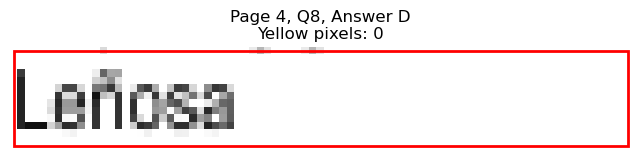


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=556.5, x1=171.1, y1=569.2
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 532
Page 4, Q9, A: Yellow percentage: 0.0%


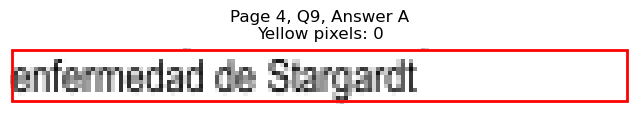

Page 4, Q9 - B: Detected box: x0=68.3, y0=569.1, x1=213.8, y1=581.8
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 730
Page 4, Q9, B: Yellow percentage: 0.0%


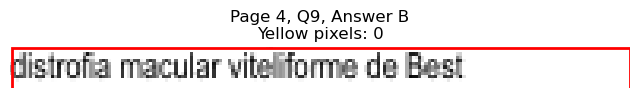

Page 4, Q9 - C: Detected box: x0=327.5, y0=556.5, x1=400.7, y1=569.2
Page 4, Q9, C: Yellow pixels: 124
Page 4, Q9, C: Total non-white pixels: 471
Page 4, Q9, C: Yellow percentage: 26.3%


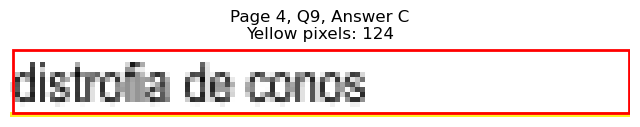

Page 4, Q9 - D: Detected box: x0=327.5, y0=569.1, x1=413.3, y1=581.8
Page 4, Q9, D: Yellow pixels: 1449
Page 4, Q9, D: Total non-white pixels: 1781
Page 4, Q9, D: Yellow percentage: 81.4%


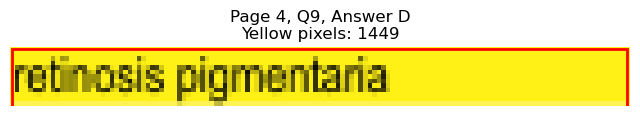


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=314.6, y1=644.9
Page 4, Q10, A: Yellow pixels: 2840
Page 4, Q10, A: Total non-white pixels: 3861
Page 4, Q10, A: Yellow percentage: 73.6%


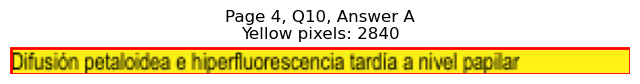

Page 4, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=384.3, y1=657.5
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 1539
Page 4, Q10, B: Yellow percentage: 0.0%


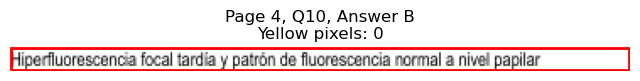

Page 4, Q10 - C: Detected box: x0=68.8, y0=657.5, x1=401.8, y1=670.1
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 1660
Page 4, Q10, C: Yellow percentage: 0.0%


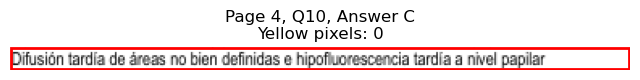

Page 4, Q10 - D: Detected box: x0=68.8, y0=670.1, x1=336.1, y1=682.7
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 1305
Page 4, Q10, D: Yellow percentage: 0.0%


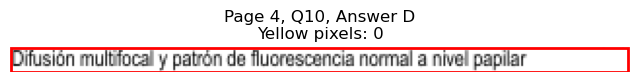


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=95.4, y1=720.6
Page 4, Q11, A: Yellow pixels: 930
Page 4, Q11, A: Total non-white pixels: 1092
Page 4, Q11, A: Yellow percentage: 85.2%


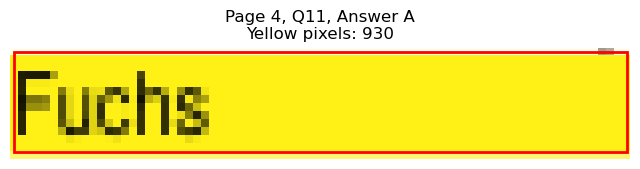

Page 4, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=105.4, y1=733.2
Page 4, Q11, B: Yellow pixels: 88
Page 4, Q11, B: Total non-white pixels: 265
Page 4, Q11, B: Yellow percentage: 33.2%


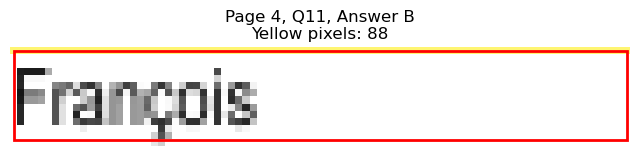

Page 4, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=368.2, y1=720.6
Page 4, Q11, C: Yellow pixels: 0
Page 4, Q11, C: Total non-white pixels: 211
Page 4, Q11, C: Yellow percentage: 0.0%


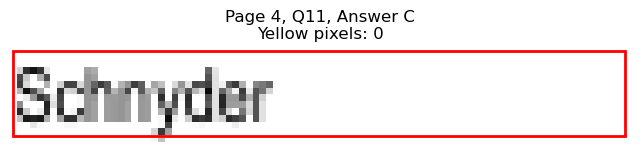

Page 4, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=354.1, y1=733.2
Page 4, Q11, D: Yellow pixels: 0
Page 4, Q11, D: Total non-white pixels: 153
Page 4, Q11, D: Yellow percentage: 0.0%


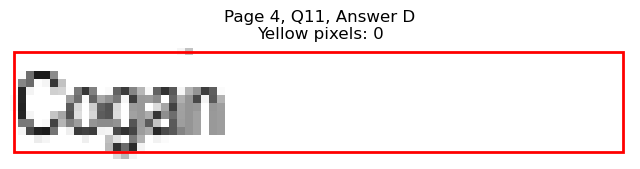


Page 4, Q11 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=89.4, y1=114.7
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 104
Page 5, Q1, A: Yellow percentage: 0.0%


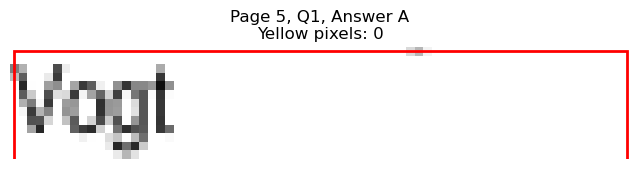

Page 5, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=100.9, y1=127.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 183
Page 5, Q1, B: Yellow percentage: 0.0%


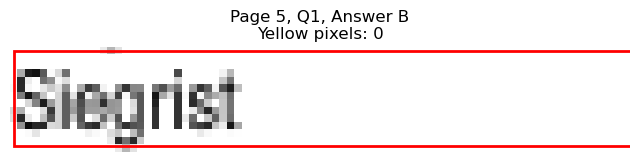

Page 5, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=351.7, y1=114.7
Page 5, Q1, C: Yellow pixels: 869
Page 5, Q1, C: Total non-white pixels: 975
Page 5, Q1, C: Yellow percentage: 89.1%


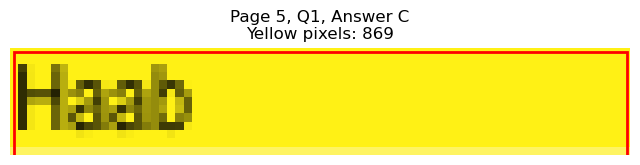

Page 5, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=351.2, y1=127.3
Page 5, Q1, D: Yellow pixels: 75
Page 5, Q1, D: Total non-white pixels: 172
Page 5, Q1, D: Yellow percentage: 43.6%


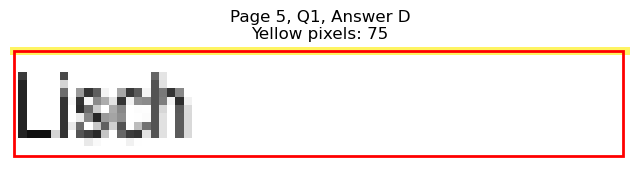


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=101.4, y1=165.2
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 170
Page 5, Q2, A: Yellow percentage: 0.0%


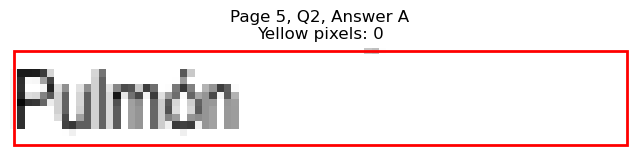

Page 5, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=99.9, y1=177.8
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 177
Page 5, Q2, B: Yellow percentage: 0.0%


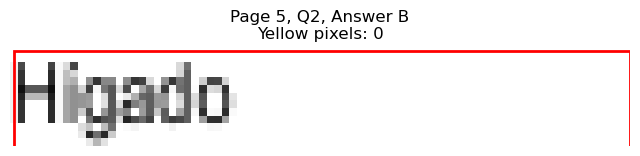

Page 5, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=345.1, y1=165.2
Page 5, Q2, C: Yellow pixels: 69
Page 5, Q2, C: Total non-white pixels: 146
Page 5, Q2, C: Yellow percentage: 47.3%


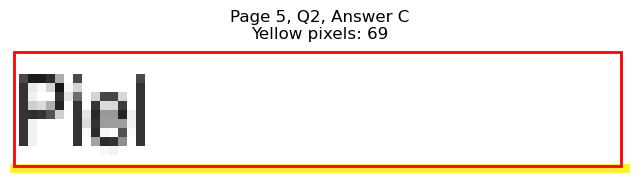

Page 5, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=355.1, y1=177.8
Page 5, Q2, D: Yellow pixels: 910
Page 5, Q2, D: Total non-white pixels: 1027
Page 5, Q2, D: Yellow percentage: 88.6%


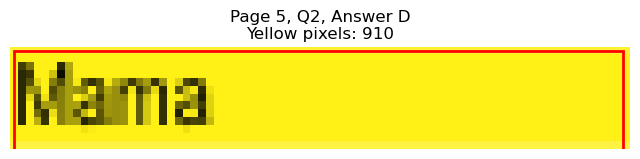


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=149.5, y1=215.6
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 423
Page 5, Q3, A: Yellow percentage: 0.0%


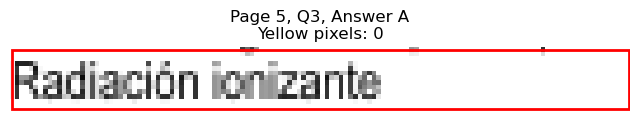

Page 5, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=124.9, y1=228.3
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 285
Page 5, Q3, B: Yellow percentage: 0.0%


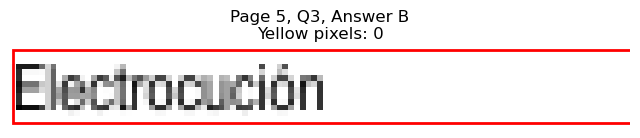

Page 5, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=370.6, y1=215.6
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 216
Page 5, Q3, C: Yellow percentage: 0.0%


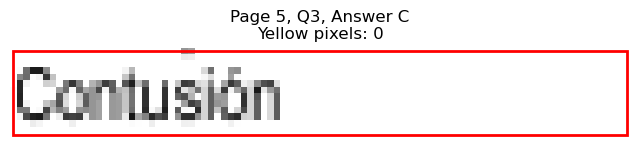

Page 5, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=408.3, y1=228.3
Page 5, Q3, D: Yellow pixels: 1263
Page 5, Q3, D: Total non-white pixels: 1848
Page 5, Q3, D: Yellow percentage: 68.3%


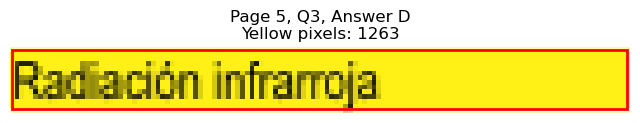


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=115.9, y1=278.7
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 243
Page 5, Q4, A: Yellow percentage: 0.0%


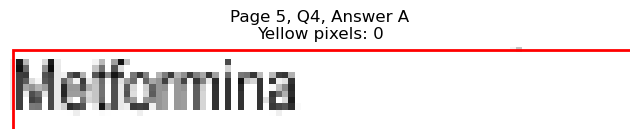

Page 5, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=103.5, y1=291.5
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 187
Page 5, Q4, B: Yellow percentage: 0.0%


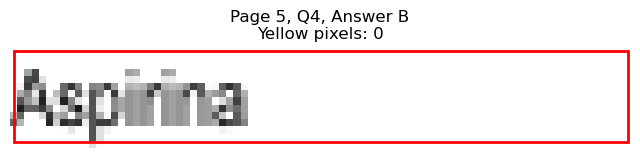

Page 5, Q4 - C: Detected box: x0=327.5, y0=266.1, x1=389.2, y1=278.7
Page 5, Q4, C: Yellow pixels: 1225
Page 5, Q4, C: Total non-white pixels: 1469
Page 5, Q4, C: Yellow percentage: 83.4%


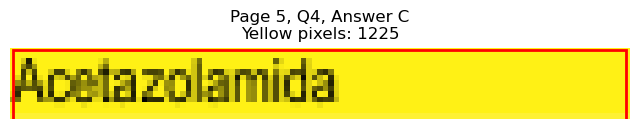

Page 5, Q4 - D: Detected box: x0=327.5, y0=278.8, x1=375.7, y1=291.5
Page 5, Q4, D: Yellow pixels: 99
Page 5, Q4, D: Total non-white pixels: 373
Page 5, Q4, D: Yellow percentage: 26.5%


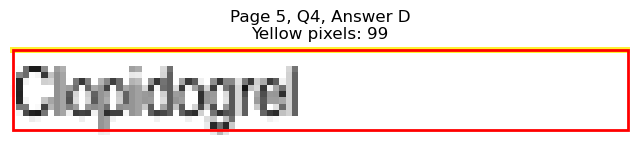


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=316.6, x1=152.1, y1=329.3
Page 5, Q5, A: Yellow pixels: 1284
Page 5, Q5, A: Total non-white pixels: 1890
Page 5, Q5, A: Yellow percentage: 67.9%


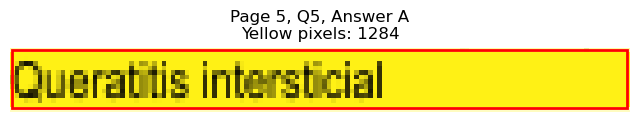

Page 5, Q5 - B: Detected box: x0=68.3, y0=329.2, x1=168.6, y1=341.9
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 641
Page 5, Q5, B: Yellow percentage: 0.0%


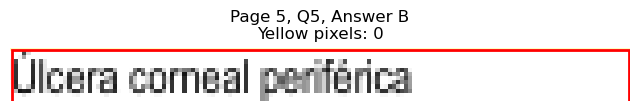

Page 5, Q5 - C: Detected box: x0=327.5, y0=316.6, x1=391.7, y1=329.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 328
Page 5, Q5, C: Yellow percentage: 0.0%


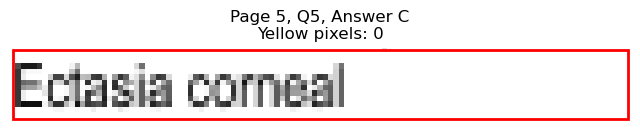

Page 5, Q5 - D: Detected box: x0=327.5, y0=329.2, x1=399.8, y1=341.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 373
Page 5, Q5, D: Yellow percentage: 0.0%


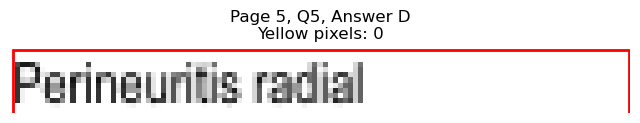


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=367.1, x1=311.6, y1=379.8
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 1157
Page 5, Q6, A: Yellow percentage: 0.0%


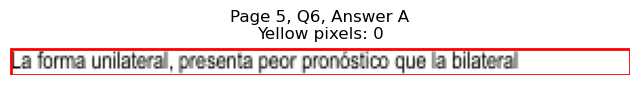

Page 5, Q6 - B: Detected box: x0=68.3, y0=379.7, x1=367.7, y1=392.4
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 1460
Page 5, Q6, B: Yellow percentage: 0.0%


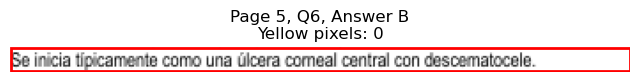

Page 5, Q6 - C: Detected box: x0=68.8, y0=392.3, x1=380.3, y1=405.0
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 1822
Page 5, Q6, C: Yellow percentage: 0.0%


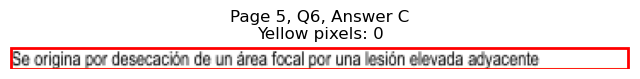

Page 5, Q6 - D: Detected box: x0=68.8, y0=404.9, x1=339.8, y1=417.6
Page 5, Q6, D: Yellow pixels: 3173
Page 5, Q6, D: Total non-white pixels: 4508
Page 5, Q6, D: Yellow percentage: 70.4%


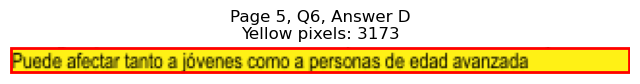


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=110.9, y1=455.5
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 255
Page 5, Q7, A: Yellow percentage: 0.0%


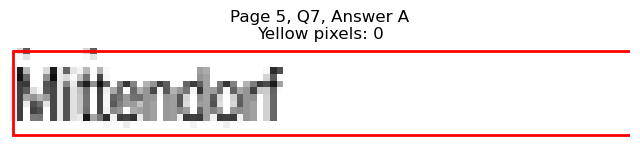

Page 5, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=117.5, y1=468.1
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 266
Page 5, Q7, B: Yellow percentage: 0.0%


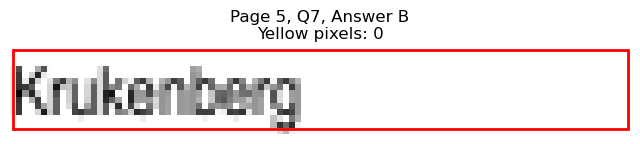

Page 5, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=362.7, y1=455.5
Page 5, Q7, C: Yellow pixels: 86
Page 5, Q7, C: Total non-white pixels: 259
Page 5, Q7, C: Yellow percentage: 33.2%


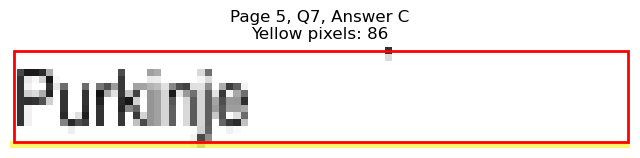

Page 5, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=378.7, y1=468.1
Page 5, Q7, D: Yellow pixels: 1109
Page 5, Q7, D: Total non-white pixels: 1428
Page 5, Q7, D: Yellow percentage: 77.7%


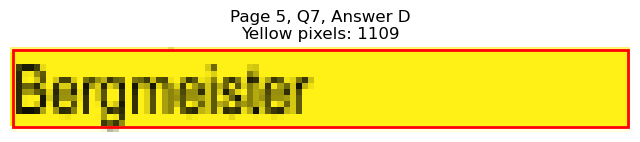


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=493.4, x1=376.7, y1=506.0
Page 5, Q8, A: Yellow pixels: 359
Page 5, Q8, A: Total non-white pixels: 2269
Page 5, Q8, A: Yellow percentage: 15.8%


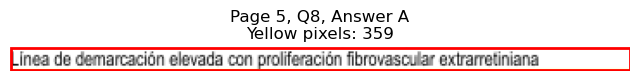

Page 5, Q8 - B: Detected box: x0=68.3, y0=506.0, x1=391.3, y1=518.6
Page 5, Q8, B: Yellow pixels: 3688
Page 5, Q8, B: Total non-white pixels: 5236
Page 5, Q8, B: Yellow percentage: 70.4%


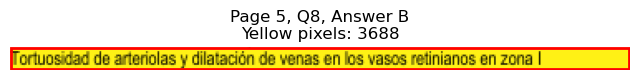

Page 5, Q8 - C: Detected box: x0=68.8, y0=518.6, x1=384.8, y1=531.2
Page 5, Q8, C: Yellow pixels: 366
Page 5, Q8, C: Total non-white pixels: 1934
Page 5, Q8, C: Yellow percentage: 18.9%


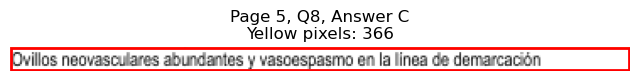

Page 5, Q8 - D: Detected box: x0=68.8, y0=531.2, x1=383.8, y1=543.8
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 1557
Page 5, Q8, D: Yellow percentage: 0.0%


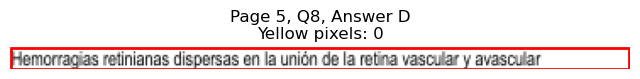


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=569.1, x1=393.3, y1=581.8
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 1638
Page 5, Q9, A: Yellow percentage: 0.0%


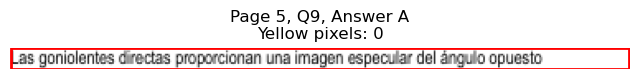

Page 5, Q9 - B: Detected box: x0=68.3, y0=581.7, x1=366.3, y1=594.4
Page 5, Q9, B: Yellow pixels: 349
Page 5, Q9, B: Total non-white pixels: 1870
Page 5, Q9, B: Yellow percentage: 18.7%


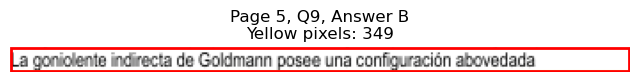

Page 5, Q9 - C: Detected box: x0=68.8, y0=594.3, x1=410.8, y1=607.0
Page 5, Q9, C: Yellow pixels: 3739
Page 5, Q9, C: Total non-white pixels: 5109
Page 5, Q9, C: Yellow percentage: 73.2%


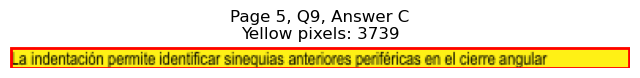

Page 5, Q9 - D: Detected box: x0=68.8, y0=606.9, x1=315.5, y1=619.6
Page 5, Q9, D: Yellow pixels: 292
Page 5, Q9, D: Total non-white pixels: 1515
Page 5, Q9, D: Yellow percentage: 19.3%


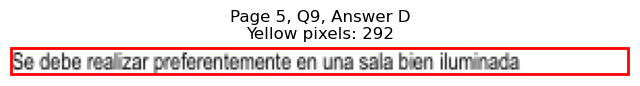


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=657.5, x1=125.4, y1=670.1
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 313
Page 5, Q10, A: Yellow percentage: 0.0%


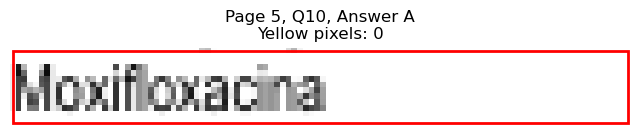

Page 5, Q10 - B: Detected box: x0=68.3, y0=670.1, x1=104.4, y1=682.7
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 178
Page 5, Q10, B: Yellow percentage: 0.0%


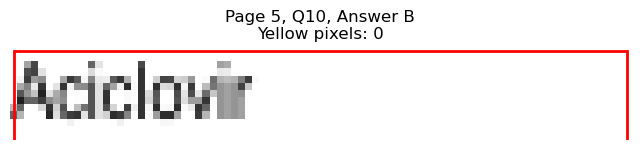

Page 5, Q10 - C: Detected box: x0=327.5, y0=657.5, x1=376.1, y1=670.1
Page 5, Q10, C: Yellow pixels: 100
Page 5, Q10, C: Total non-white pixels: 349
Page 5, Q10, C: Yellow percentage: 28.7%


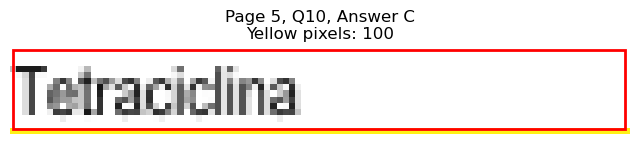

Page 5, Q10 - D: Detected box: x0=327.5, y0=670.1, x1=382.7, y1=682.7
Page 5, Q10, D: Yellow pixels: 1171
Page 5, Q10, D: Total non-white pixels: 1378
Page 5, Q10, D: Yellow percentage: 85.0%


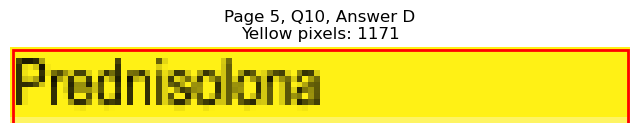


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=708.0, x1=140.1, y1=720.6
Page 5, Q11, A: Yellow pixels: 123
Page 5, Q11, A: Total non-white pixels: 532
Page 5, Q11, A: Yellow percentage: 23.1%


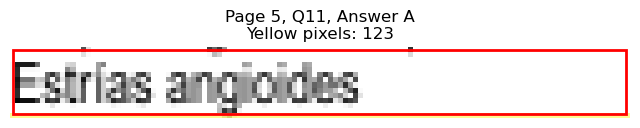

Page 5, Q11 - B: Detected box: x0=68.3, y0=720.6, x1=203.7, y1=733.2
Page 5, Q11, B: Yellow pixels: 1897
Page 5, Q11, B: Total non-white pixels: 2604
Page 5, Q11, B: Yellow percentage: 72.8%


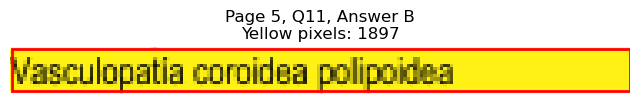

Page 5, Q11 - C: Detected box: x0=327.5, y0=708.0, x1=403.7, y1=720.6
Page 5, Q11, C: Yellow pixels: 0
Page 5, Q11, C: Total non-white pixels: 367
Page 5, Q11, C: Yellow percentage: 0.0%


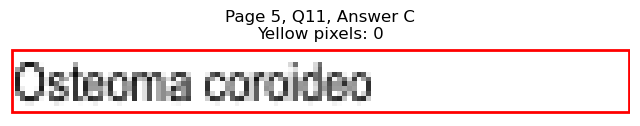

Page 5, Q11 - D: Detected box: x0=327.5, y0=720.6, x1=446.4, y1=733.2
Page 5, Q11, D: Yellow pixels: 0
Page 5, Q11, D: Total non-white pixels: 601
Page 5, Q11, D: Yellow percentage: 0.0%


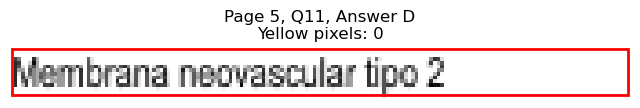


Page 5, Q11 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 12 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=246.4, y1=102.1
Page 6, Q1, A: Yellow pixels: 2276
Page 6, Q1, A: Total non-white pixels: 3206
Page 6, Q1, A: Yellow percentage: 71.0%


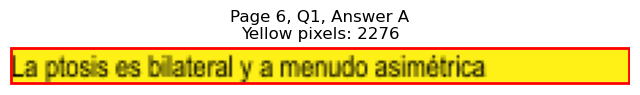

Page 6, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=283.5, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 1327
Page 6, Q1, B: Yellow percentage: 0.0%


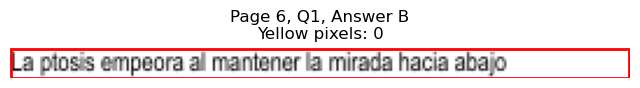

Page 6, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=257.4, y1=127.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 897
Page 6, Q1, C: Yellow percentage: 0.0%


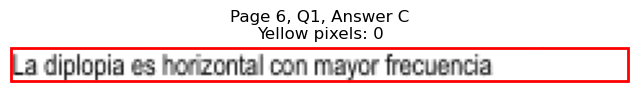

Page 6, Q1 - D: Detected box: x0=68.8, y0=127.2, x1=256.4, y1=139.9
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 888
Page 6, Q1, D: Yellow percentage: 0.0%


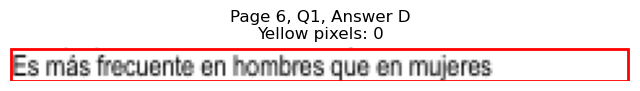


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=235.4, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 849
Page 6, Q2, A: Yellow percentage: 0.0%


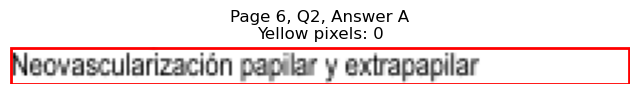

Page 6, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=216.8, y1=190.4
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 727
Page 6, Q2, B: Yellow percentage: 0.0%


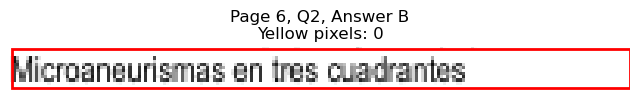

Page 6, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=253.4, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 1102
Page 6, Q2, C: Yellow percentage: 0.0%


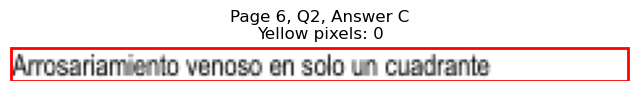

Page 6, Q2 - D: Detected box: x0=68.8, y0=202.9, x1=291.5, y1=215.6
Page 6, Q2, D: Yellow pixels: 2717
Page 6, Q2, D: Total non-white pixels: 3836
Page 6, Q2, D: Yellow percentage: 70.8%


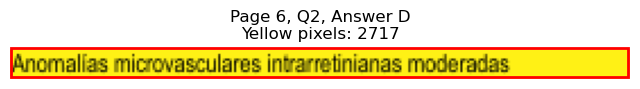


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=56.6, y0=253.5, x1=65.2, y1=266.1
Page 6, Q3, A: Yellow pixels: 731
Page 6, Q3, A: Total non-white pixels: 840
Page 6, Q3, A: Yellow percentage: 87.0%


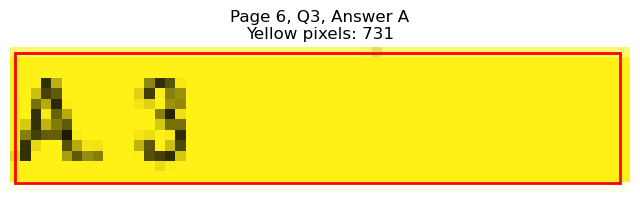

Page 6, Q3 - B: Detected box: x0=56.6, y0=266.1, x1=65.2, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 129
Page 6, Q3, B: Yellow percentage: 0.0%


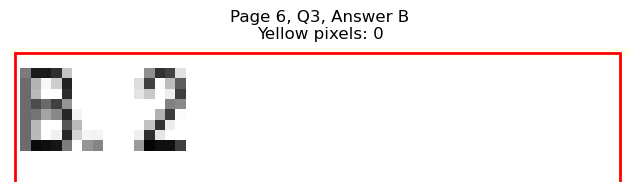

Page 6, Q3 - C: Detected box: x0=315.4, y0=253.5, x1=324.4, y1=266.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 65
Page 6, Q3, C: Yellow percentage: 0.0%


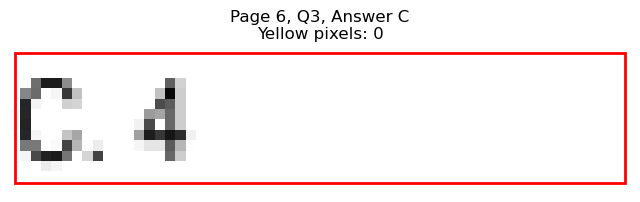

Page 6, Q3 - D: Detected box: x0=315.4, y0=266.1, x1=324.4, y1=278.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 53
Page 6, Q3, D: Yellow percentage: 0.0%


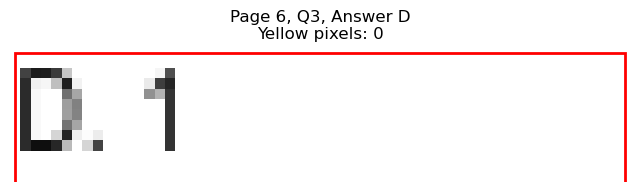


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=167.1, y1=316.7
Page 6, Q4, A: Yellow pixels: 1557
Page 6, Q4, A: Total non-white pixels: 1950
Page 6, Q4, A: Yellow percentage: 79.8%


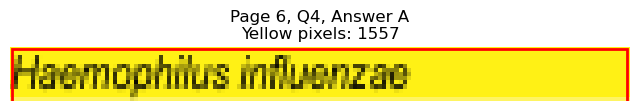

Page 6, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=171.1, y1=329.3
Page 6, Q4, B: Yellow pixels: 154
Page 6, Q4, B: Total non-white pixels: 671
Page 6, Q4, B: Yellow percentage: 23.0%


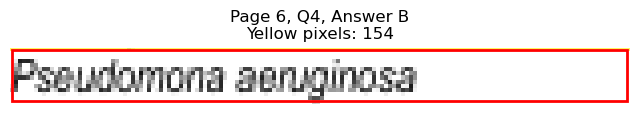

Page 6, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=423.3, y1=316.7
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 485
Page 6, Q4, C: Yellow percentage: 0.0%


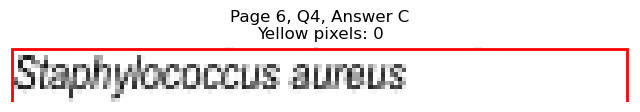

Page 6, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=428.8, y1=329.3
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 524
Page 6, Q4, D: Yellow percentage: 0.0%


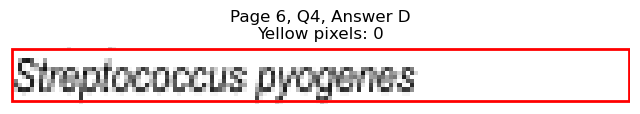


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=181.1, y1=379.8
Page 6, Q5, A: Yellow pixels: 1690
Page 6, Q5, A: Total non-white pixels: 2132
Page 6, Q5, A: Yellow percentage: 79.3%


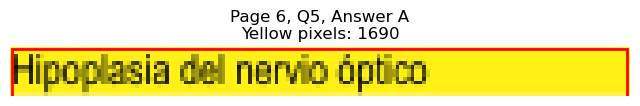

Page 6, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=180.1, y1=392.4
Page 6, Q5, B: Yellow pixels: 163
Page 6, Q5, B: Total non-white pixels: 706
Page 6, Q5, B: Yellow percentage: 23.1%


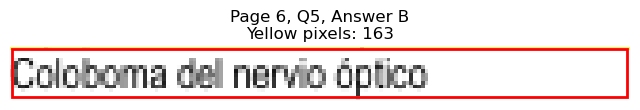

Page 6, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=437.8, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 535
Page 6, Q5, C: Yellow percentage: 0.0%


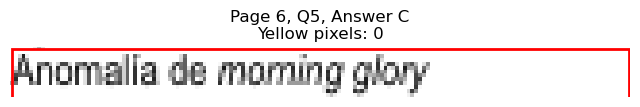

Page 6, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=422.3, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 491
Page 6, Q5, D: Yellow percentage: 0.0%


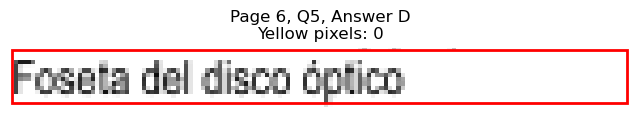


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=200.8, y1=430.3
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 647
Page 6, Q6, A: Yellow percentage: 0.0%


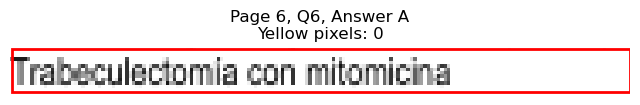

Page 6, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=205.2, y1=442.9
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 685
Page 6, Q6, B: Yellow percentage: 0.0%


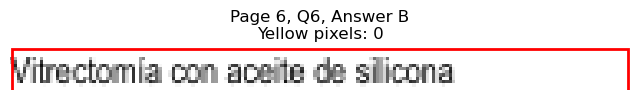

Page 6, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=476.5, y1=430.3
Page 6, Q6, C: Yellow pixels: 1807
Page 6, Q6, C: Total non-white pixels: 2800
Page 6, Q6, C: Yellow percentage: 64.5%


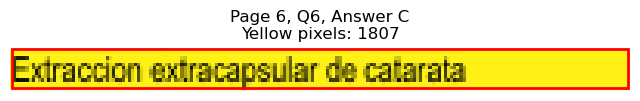

Page 6, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=415.3, y1=442.9
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 580
Page 6, Q6, D: Yellow percentage: 0.0%


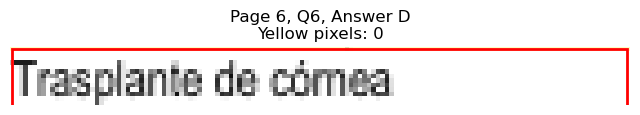


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=468.1, x1=106.9, y1=480.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 202
Page 6, Q7, A: Yellow percentage: 0.0%


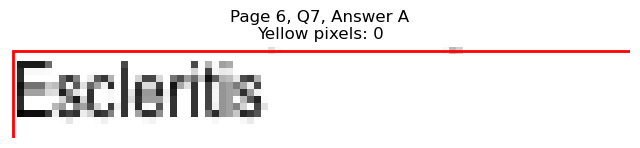

Page 6, Q7 - B: Detected box: x0=68.3, y0=480.8, x1=112.0, y1=493.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 205
Page 6, Q7, B: Yellow percentage: 0.0%


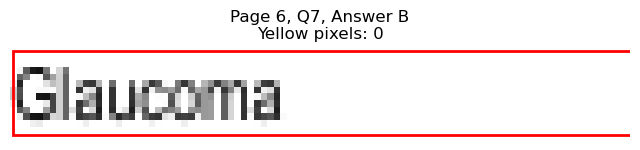

Page 6, Q7 - C: Detected box: x0=327.5, y0=468.1, x1=378.7, y1=480.7
Page 6, Q7, C: Yellow pixels: 1116
Page 6, Q7, C: Total non-white pixels: 1326
Page 6, Q7, C: Yellow percentage: 84.2%


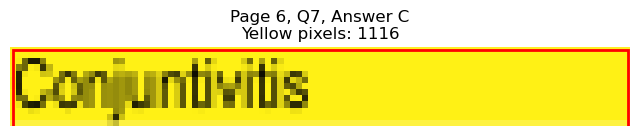

Page 6, Q7 - D: Detected box: x0=327.5, y0=480.8, x1=361.1, y1=493.4
Page 6, Q7, D: Yellow pixels: 84
Page 6, Q7, D: Total non-white pixels: 267
Page 6, Q7, D: Yellow percentage: 31.5%


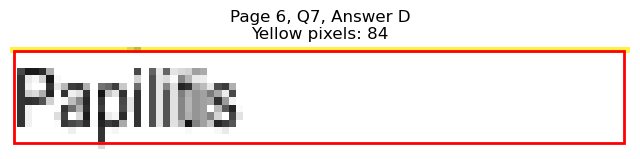


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=86.3, y1=543.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 141
Page 6, Q8, A: Yellow percentage: 0.0%


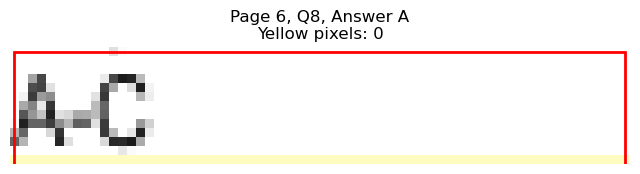

Page 6, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=86.3, y1=556.4
Page 6, Q8, B: Yellow pixels: 837
Page 6, Q8, B: Total non-white pixels: 966
Page 6, Q8, B: Yellow percentage: 86.6%


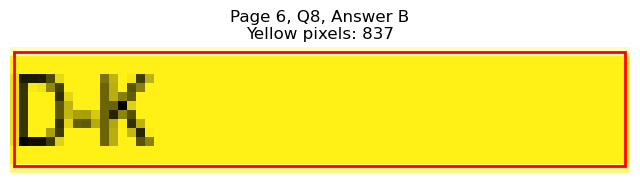

Page 6, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=345.5, y1=543.8
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 65
Page 6, Q8, C: Yellow percentage: 0.0%


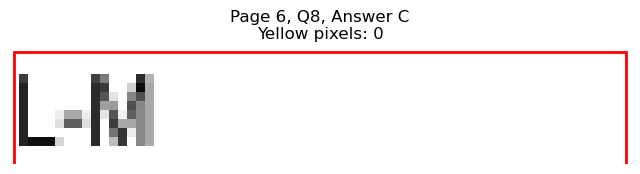

Page 6, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=346.1, y1=556.4
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 80
Page 6, Q8, D: Yellow percentage: 0.0%


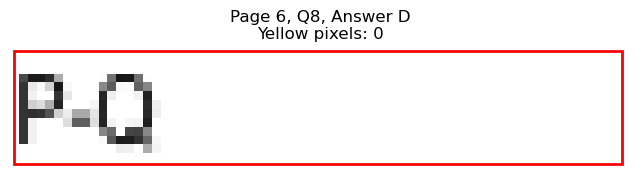


Page 6, Q8 - Selected Answer: B (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=581.7, x1=119.4, y1=594.4
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 279
Page 6, Q9, A: Yellow percentage: 0.0%


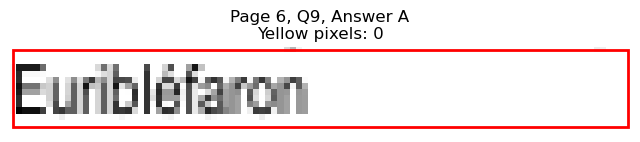

Page 6, Q9 - B: Detected box: x0=68.3, y0=594.3, x1=133.5, y1=607.0
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 334
Page 6, Q9, B: Yellow percentage: 0.0%


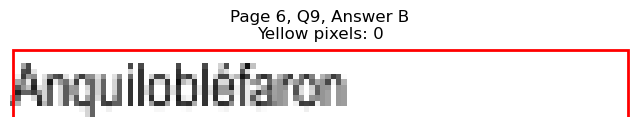

Page 6, Q9 - C: Detected box: x0=327.5, y0=581.7, x1=380.7, y1=594.4
Page 6, Q9, C: Yellow pixels: 1025
Page 6, Q9, C: Total non-white pixels: 1456
Page 6, Q9, C: Yellow percentage: 70.4%


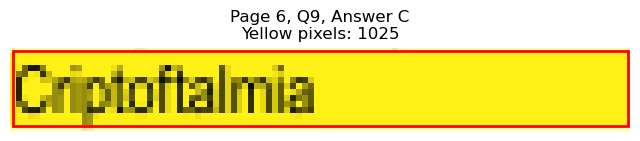

Page 6, Q9 - D: Detected box: x0=327.5, y0=594.3, x1=384.7, y1=607.0
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 419
Page 6, Q9, D: Yellow percentage: 0.0%


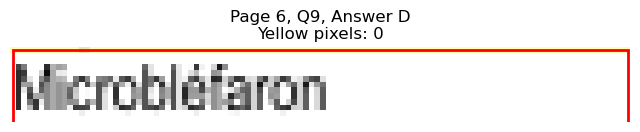


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=632.2, x1=183.6, y1=644.9
Page 6, Q10, A: Yellow pixels: 1670
Page 6, Q10, A: Total non-white pixels: 2158
Page 6, Q10, A: Yellow percentage: 77.4%


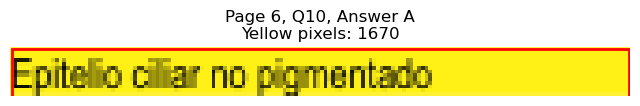

Page 6, Q10 - B: Detected box: x0=68.3, y0=644.9, x1=171.1, y1=657.5
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 561
Page 6, Q10, B: Yellow percentage: 0.0%


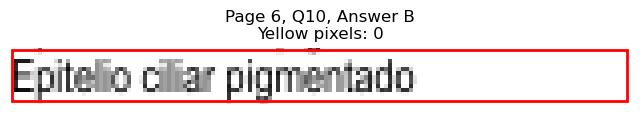

Page 6, Q10 - C: Detected box: x0=327.5, y0=632.2, x1=437.8, y1=644.9
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 573
Page 6, Q10, C: Yellow percentage: 0.0%


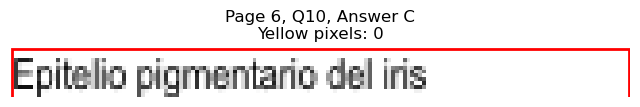

Page 6, Q10 - D: Detected box: x0=327.5, y0=644.9, x1=429.3, y1=657.5
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 518
Page 6, Q10, D: Yellow percentage: 0.0%


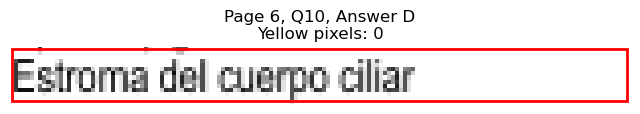


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)




Page 6, Q11 - A: Detected box: x0=68.3, y0=682.7, x1=184.1, y1=695.3
Page 6, Q11, A: Yellow pixels: 0
Page 6, Q11, A: Total non-white pixels: 587
Page 6, Q11, A: Yellow percentage: 0.0%


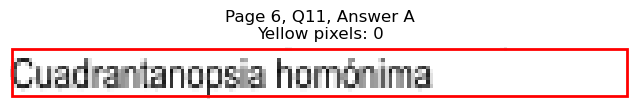

Page 6, Q11 - B: Detected box: x0=68.3, y0=695.4, x1=159.6, y1=708.0
Page 6, Q11, B: Yellow pixels: 0
Page 6, Q11, B: Total non-white pixels: 458
Page 6, Q11, B: Yellow percentage: 0.0%


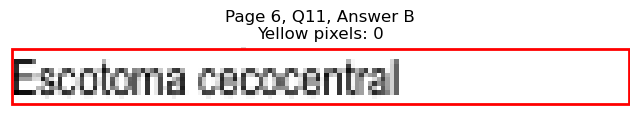

Page 6, Q11 - C: Detected box: x0=327.5, y0=682.7, x1=446.5, y1=695.3
Page 6, Q11, C: Yellow pixels: 0
Page 6, Q11, C: Total non-white pixels: 621
Page 6, Q11, C: Yellow percentage: 0.0%


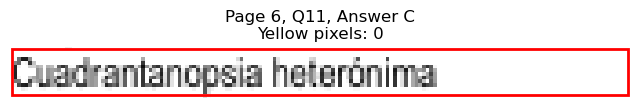

Page 6, Q11 - D: Detected box: x0=327.5, y0=695.4, x1=423.3, y1=708.0
Page 6, Q11, D: Yellow pixels: 1539
Page 6, Q11, D: Total non-white pixels: 1912
Page 6, Q11, D: Yellow percentage: 80.5%


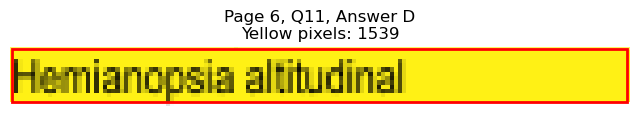


Page 6, Q11 - Selected Answer: D (based on yellow pixel count)




Page 6, Q12 - A: Detected box: x0=68.3, y0=745.8, x1=208.2, y1=758.4
Page 6, Q12, A: Yellow pixels: 0
Page 6, Q12, A: Total non-white pixels: 728
Page 6, Q12, A: Yellow percentage: 0.0%


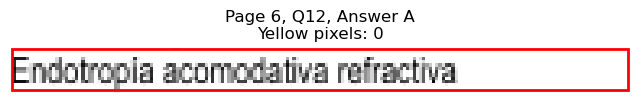

Page 6, Q12 - B: Detected box: x0=68.3, y0=758.5, x1=175.6, y1=771.2
Page 6, Q12, B: Yellow pixels: 0
Page 6, Q12, B: Total non-white pixels: 489
Page 6, Q12, B: Yellow percentage: 0.0%


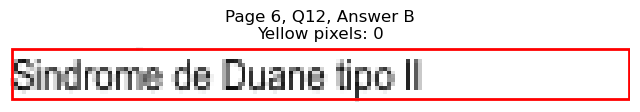

Page 6, Q12 - C: Detected box: x0=327.5, y0=745.8, x1=456.4, y1=758.4
Page 6, Q12, C: Yellow pixels: 1824
Page 6, Q12, C: Total non-white pixels: 2520
Page 6, Q12, C: Yellow percentage: 72.4%


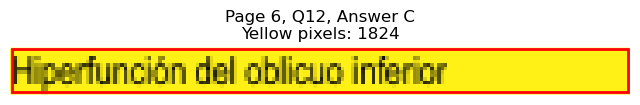

Page 6, Q12 - D: Detected box: x0=327.5, y0=758.5, x1=409.3, y1=771.2
Page 6, Q12, D: Yellow pixels: 133
Page 6, Q12, D: Total non-white pixels: 509
Page 6, Q12, D: Yellow percentage: 26.1%


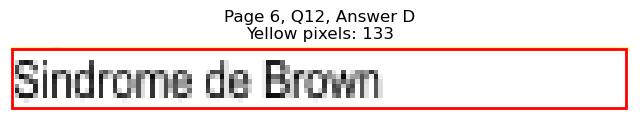


Page 6, Q12 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 11 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=138.0, y1=102.1
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 347
Page 7, Q1, A: Yellow percentage: 0.0%


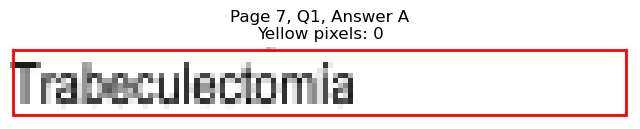

Page 7, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=155.1, y1=114.7
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 431
Page 7, Q1, B: Yellow percentage: 0.0%


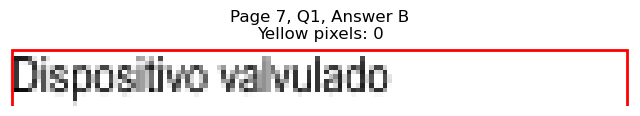

Page 7, Q1 - C: Detected box: x0=327.5, y0=89.4, x1=396.3, y1=102.1
Page 7, Q1, C: Yellow pixels: 120
Page 7, Q1, C: Total non-white pixels: 475
Page 7, Q1, C: Yellow percentage: 25.3%


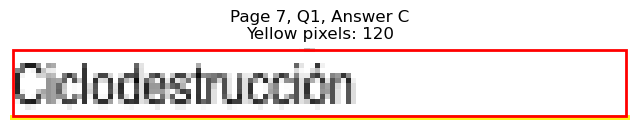

Page 7, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=418.9, y1=114.7
Page 7, Q1, D: Yellow pixels: 1490
Page 7, Q1, D: Total non-white pixels: 1846
Page 7, Q1, D: Yellow percentage: 80.7%


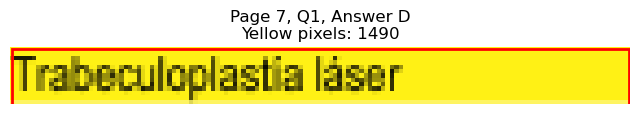


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=139.9, x1=257.8, y1=152.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 1008
Page 7, Q2, A: Yellow percentage: 0.0%


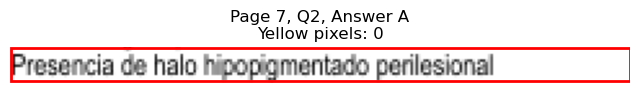

Page 7, Q2 - B: Detected box: x0=68.3, y0=152.5, x1=248.8, y1=165.2
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 872
Page 7, Q2, B: Yellow percentage: 0.0%


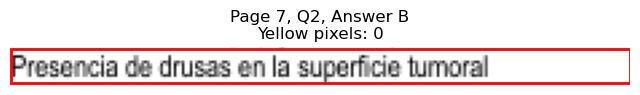

Page 7, Q2 - C: Detected box: x0=327.5, y0=139.9, x1=443.9, y1=152.6
Page 7, Q2, C: Yellow pixels: 1718
Page 7, Q2, C: Total non-white pixels: 2338
Page 7, Q2, C: Yellow percentage: 73.5%


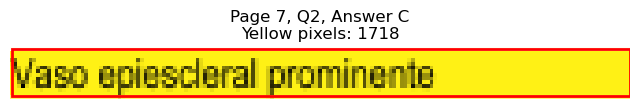

Page 7, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=468.5, y1=165.2
Page 7, Q2, D: Yellow pixels: 192
Page 7, Q2, D: Total non-white pixels: 904
Page 7, Q2, D: Yellow percentage: 21.2%


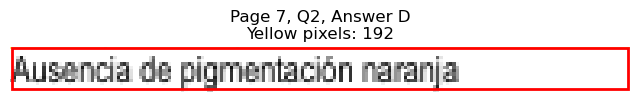


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=190.3, x1=317.2, y1=203.0
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 1525
Page 7, Q3, A: Yellow percentage: 0.0%


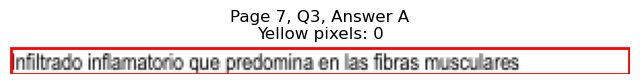

Page 7, Q3 - B: Detected box: x0=68.3, y0=202.9, x1=283.5, y1=215.6
Page 7, Q3, B: Yellow pixels: 2665
Page 7, Q3, B: Total non-white pixels: 3724
Page 7, Q3, B: Yellow percentage: 71.6%


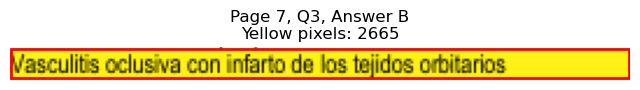

Page 7, Q3 - C: Detected box: x0=68.8, y0=215.7, x1=348.7, y1=228.3
Page 7, Q3, C: Yellow pixels: 330
Page 7, Q3, C: Total non-white pixels: 1732
Page 7, Q3, C: Yellow percentage: 19.1%


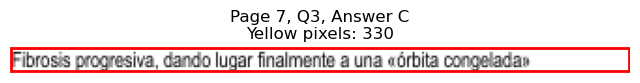

Page 7, Q3 - D: Detected box: x0=68.8, y0=228.3, x1=258.4, y1=240.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 943
Page 7, Q3, D: Yellow percentage: 0.0%


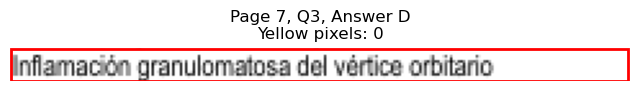


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=266.1, x1=331.1, y1=278.7
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 1292
Page 7, Q4, A: Yellow percentage: 0.0%


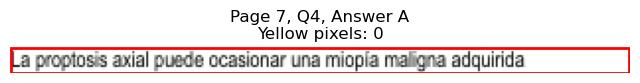

Page 7, Q4 - B: Detected box: x0=68.3, y0=278.8, x1=398.3, y1=291.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 1679
Page 7, Q4, B: Yellow percentage: 0.0%


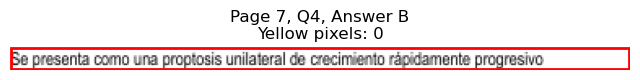

Page 7, Q4 - C: Detected box: x0=68.8, y0=291.4, x1=350.7, y1=304.1
Page 7, Q4, C: Yellow pixels: 333
Page 7, Q4, C: Total non-white pixels: 1651
Page 7, Q4, C: Yellow percentage: 20.2%


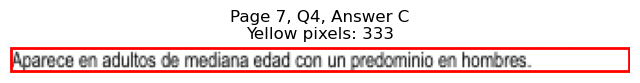

Page 7, Q4 - D: Detected box: x0=68.8, y0=304.0, x1=332.1, y1=316.7
Page 7, Q4, D: Yellow pixels: 3095
Page 7, Q4, D: Total non-white pixels: 4095
Page 7, Q4, D: Yellow percentage: 75.6%


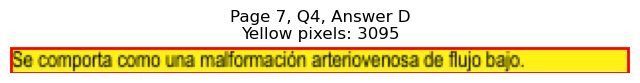


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=144.0, y1=354.6
Page 7, Q5, A: Yellow pixels: 127
Page 7, Q5, A: Total non-white pixels: 505
Page 7, Q5, A: Yellow percentage: 25.1%


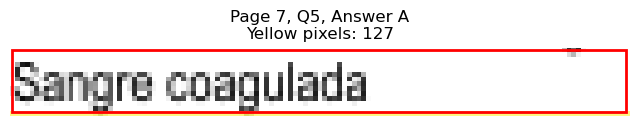

Page 7, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=141.5, y1=367.2
Page 7, Q5, B: Yellow pixels: 1326
Page 7, Q5, B: Total non-white pixels: 1736
Page 7, Q5, B: Yellow percentage: 76.4%


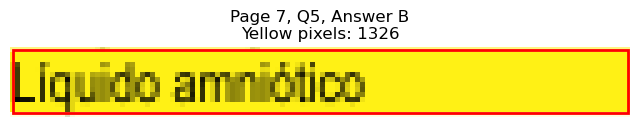

Page 7, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=398.2, y1=354.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 352
Page 7, Q5, C: Yellow percentage: 0.0%


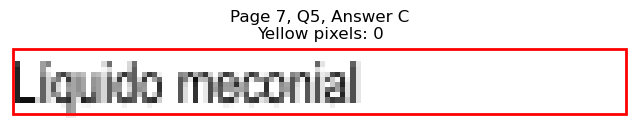

Page 7, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=372.2, y1=367.2
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 232
Page 7, Q5, D: Yellow percentage: 0.0%


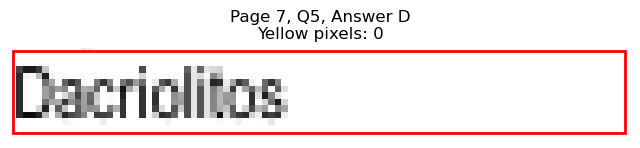


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=103.5, y1=405.0
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 265
Page 7, Q6, A: Yellow percentage: 0.0%


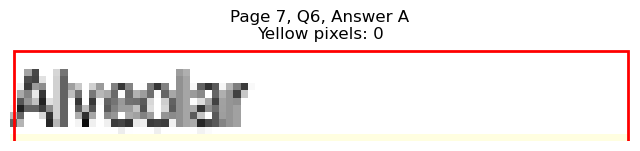

Page 7, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=119.4, y1=417.6
Page 7, Q6, B: Yellow pixels: 1112
Page 7, Q6, B: Total non-white pixels: 1428
Page 7, Q6, B: Yellow percentage: 77.9%


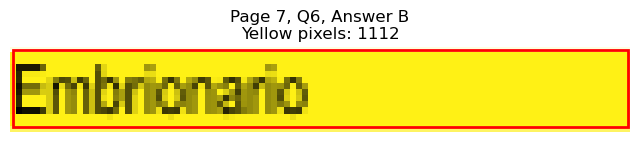

Page 7, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=365.7, y1=405.0
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 213
Page 7, Q6, C: Yellow percentage: 0.0%


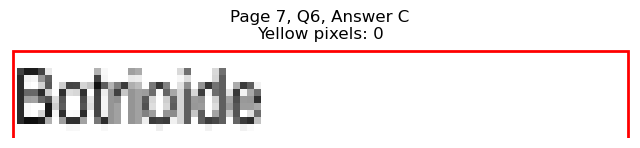

Page 7, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=371.2, y1=417.6
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 205
Page 7, Q6, D: Yellow percentage: 0.0%


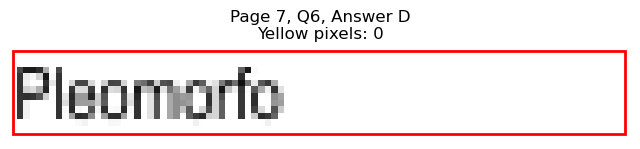


Page 7, Q6 - Selected Answer: B (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=264.9, y1=455.5
Page 7, Q7, A: Yellow pixels: 247
Page 7, Q7, A: Total non-white pixels: 1198
Page 7, Q7, A: Yellow percentage: 20.6%


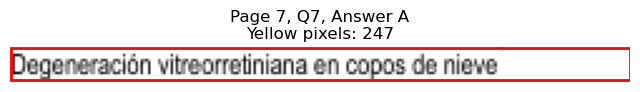

Page 7, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=271.5, y1=468.1
Page 7, Q7, B: Yellow pixels: 2458
Page 7, Q7, B: Total non-white pixels: 3556
Page 7, Q7, B: Yellow percentage: 69.1%


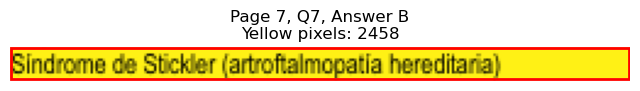

Page 7, Q7 - C: Detected box: x0=68.8, y0=468.1, x1=352.1, y1=480.7
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 1769
Page 7, Q7, C: Yellow percentage: 0.0%


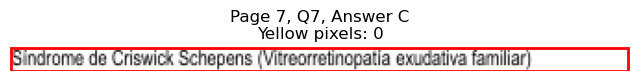

Page 7, Q7 - D: Detected box: x0=68.8, y0=480.8, x1=263.3, y1=493.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 1004
Page 7, Q7, D: Yellow percentage: 0.0%


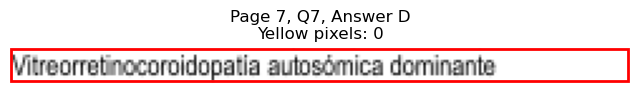


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=150.1, y1=543.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 434
Page 7, Q8, A: Yellow percentage: 0.0%


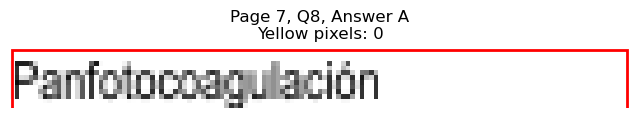

Page 7, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=116.4, y1=556.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 249
Page 7, Q8, B: Yellow percentage: 0.0%


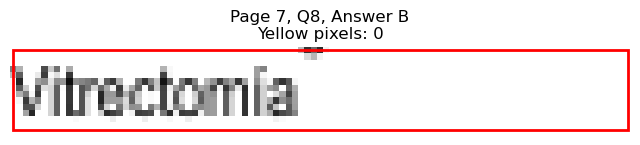

Page 7, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=380.7, y1=543.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 367
Page 7, Q8, C: Yellow percentage: 0.0%


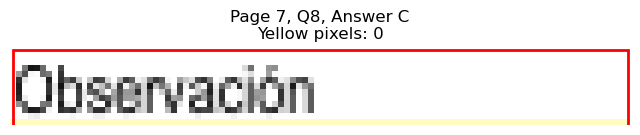

Page 7, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=398.8, y1=556.4
Page 7, Q8, D: Yellow pixels: 1274
Page 7, Q8, D: Total non-white pixels: 1708
Page 7, Q8, D: Yellow percentage: 74.6%


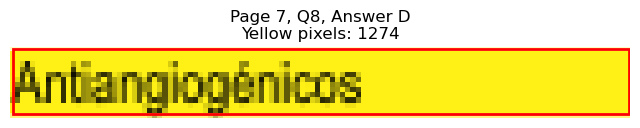


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=109.5, y1=632.3
Page 7, Q9, A: Yellow pixels: 941
Page 7, Q9, A: Total non-white pixels: 1288
Page 7, Q9, A: Yellow percentage: 73.1%


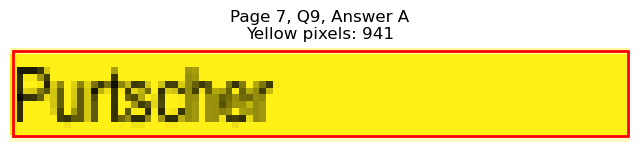

Page 7, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=110.9, y1=644.9
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 317
Page 7, Q9, B: Yellow percentage: 0.0%


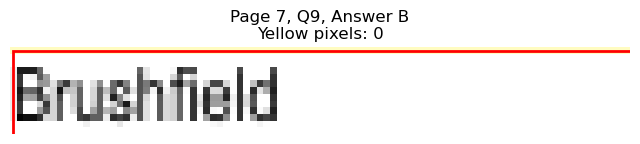

Page 7, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=364.1, y1=632.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 185
Page 7, Q9, C: Yellow percentage: 0.0%


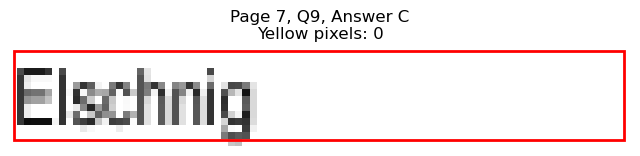

Page 7, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=360.2, y1=644.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 157
Page 7, Q9, D: Yellow percentage: 0.0%


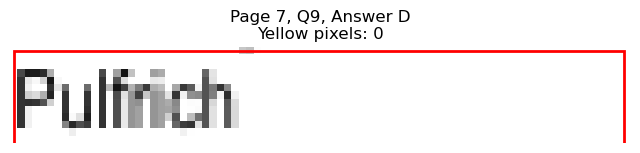


Page 7, Q9 - Selected Answer: A (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=118.5, y1=682.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 266
Page 7, Q10, A: Yellow percentage: 0.0%


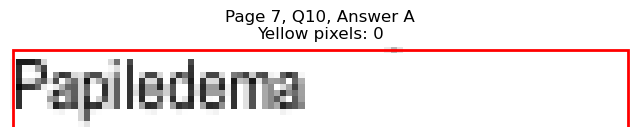

Page 7, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=217.7, y1=695.3
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 749
Page 7, Q10, B: Yellow percentage: 0.0%


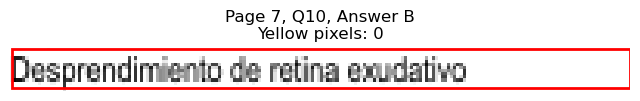

Page 7, Q10 - C: Detected box: x0=327.5, y0=670.1, x1=423.3, y1=682.7
Page 7, Q10, C: Yellow pixels: 1526
Page 7, Q10, C: Total non-white pixels: 1911
Page 7, Q10, C: Yellow percentage: 79.9%


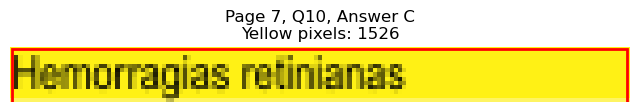

Page 7, Q10 - D: Detected box: x0=327.5, y0=682.7, x1=413.3, y1=695.3
Page 7, Q10, D: Yellow pixels: 135
Page 7, Q10, D: Total non-white pixels: 584
Page 7, Q10, D: Yellow percentage: 23.1%


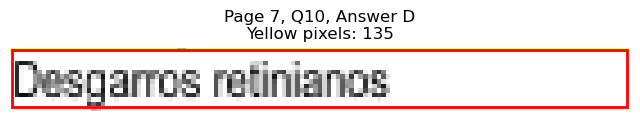


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)




Page 7, Q11 - A: Detected box: x0=68.3, y0=720.6, x1=124.9, y1=733.2
Page 7, Q11, A: Yellow pixels: 0
Page 7, Q11, A: Total non-white pixels: 316
Page 7, Q11, A: Yellow percentage: 0.0%


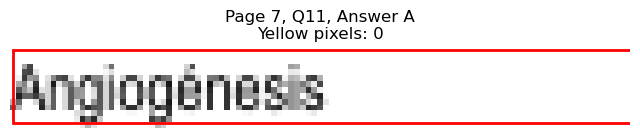

Page 7, Q11 - B: Detected box: x0=68.3, y0=733.2, x1=149.1, y1=745.8
Page 7, Q11, B: Yellow pixels: 0
Page 7, Q11, B: Total non-white pixels: 392
Page 7, Q11, B: Yellow percentage: 0.0%


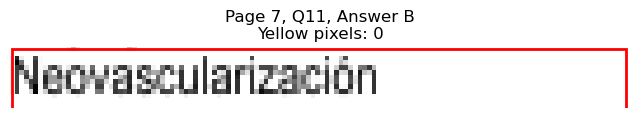

Page 7, Q11 - C: Detected box: x0=327.5, y0=720.6, x1=393.3, y1=733.2
Page 7, Q11, C: Yellow pixels: 1269
Page 7, Q11, C: Total non-white pixels: 1638
Page 7, Q11, C: Yellow percentage: 77.5%


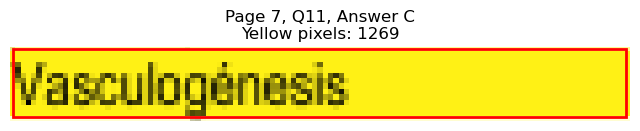

Page 7, Q11 - D: Detected box: x0=327.5, y0=733.2, x1=402.3, y1=745.8
Page 7, Q11, D: Yellow pixels: 0
Page 7, Q11, D: Total non-white pixels: 526
Page 7, Q11, D: Yellow percentage: 0.0%


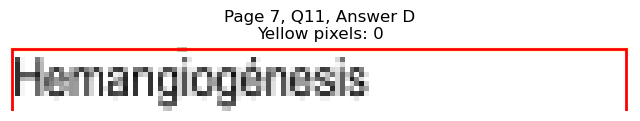


Page 7, Q11 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=127.5, y1=127.3
Page 8, Q1, A: Yellow pixels: 1093
Page 8, Q1, A: Total non-white pixels: 1540
Page 8, Q1, A: Yellow percentage: 71.0%


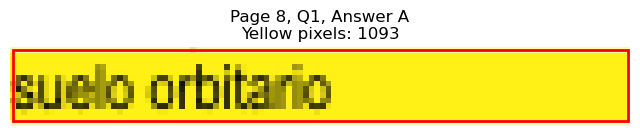

Page 8, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=123.0, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 362
Page 8, Q1, B: Yellow percentage: 0.0%


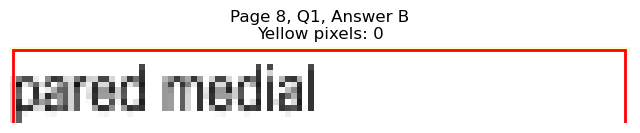

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=387.2, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 302
Page 8, Q1, C: Yellow percentage: 0.0%


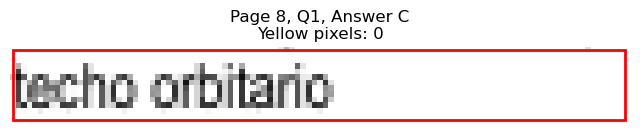

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=380.2, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 263
Page 8, Q1, D: Yellow percentage: 0.0%


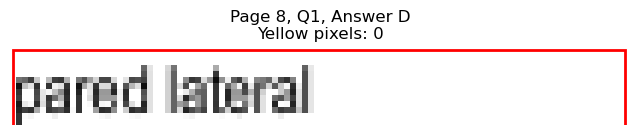


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=124.9, y1=177.8
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 391
Page 8, Q2, A: Yellow percentage: 0.0%


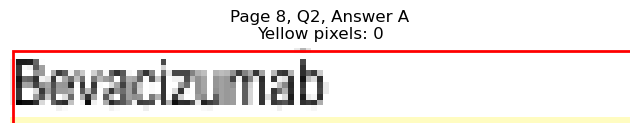

Page 8, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=119.4, y1=190.4
Page 8, Q2, B: Yellow pixels: 1010
Page 8, Q2, B: Total non-white pixels: 1428
Page 8, Q2, B: Yellow percentage: 70.7%


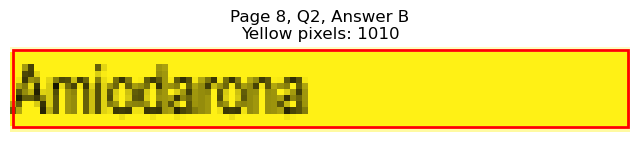

Page 8, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=388.7, y1=177.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 316
Page 8, Q2, C: Yellow percentage: 0.0%


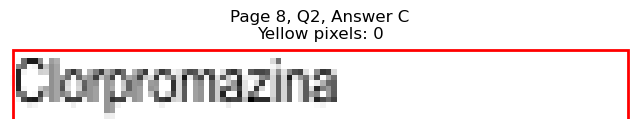

Page 8, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=370.1, y1=190.4
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 207
Page 8, Q2, D: Yellow percentage: 0.0%


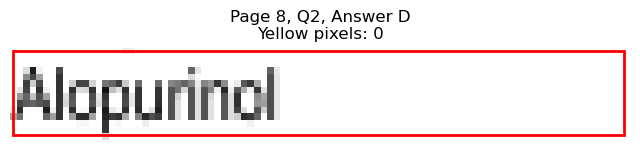


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=299.6, y1=228.3
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 1111
Page 8, Q3, A: Yellow percentage: 0.0%


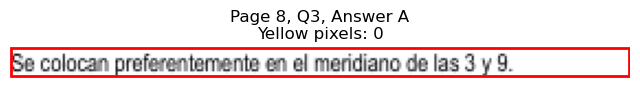

Page 8, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=434.0, y1=240.9
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 1779
Page 8, Q3, B: Yellow percentage: 0.0%


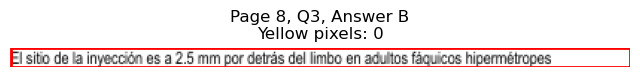

Page 8, Q3 - C: Detected box: x0=68.8, y0=240.9, x1=323.7, y1=253.5
Page 8, Q3, C: Yellow pixels: 306
Page 8, Q3, C: Total non-white pixels: 1556
Page 8, Q3, C: Yellow percentage: 19.7%


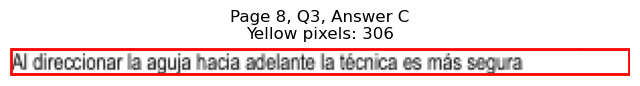

Page 8, Q3 - D: Detected box: x0=68.8, y0=253.5, x1=369.2, y1=266.1
Page 8, Q3, D: Yellow pixels: 3403
Page 8, Q3, D: Total non-white pixels: 4928
Page 8, Q3, D: Yellow percentage: 69.1%


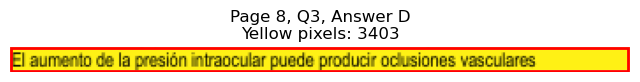


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=166.1, y1=304.1
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 472
Page 8, Q4, A: Yellow percentage: 0.0%


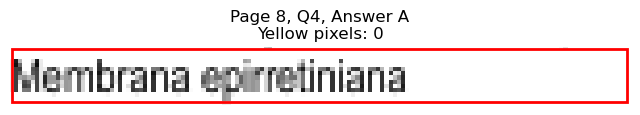

Page 8, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=162.0, y1=316.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 447
Page 8, Q4, B: Yellow percentage: 0.0%


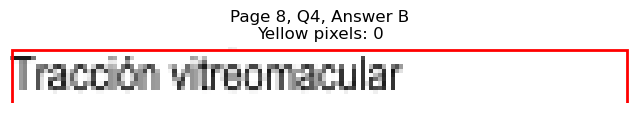

Page 8, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=393.2, y1=304.1
Page 8, Q4, C: Yellow pixels: 117
Page 8, Q4, C: Total non-white pixels: 434
Page 8, Q4, C: Yellow percentage: 27.0%


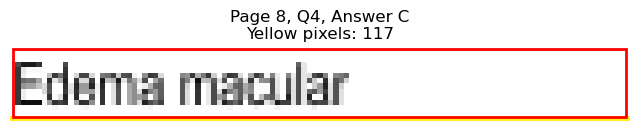

Page 8, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=395.7, y1=316.7
Page 8, Q4, D: Yellow pixels: 1279
Page 8, Q4, D: Total non-white pixels: 1547
Page 8, Q4, D: Yellow percentage: 82.7%


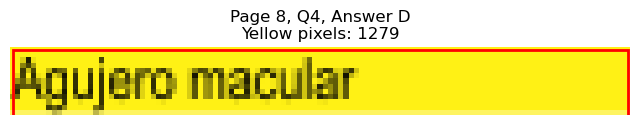


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=341.9, x1=132.1, y1=354.6
Page 8, Q5, A: Yellow pixels: 1259
Page 8, Q5, A: Total non-white pixels: 1610
Page 8, Q5, A: Yellow percentage: 78.2%


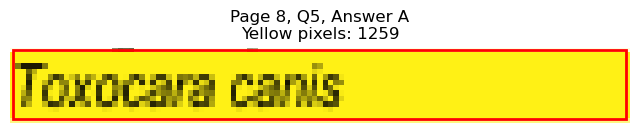

Page 8, Q5 - B: Detected box: x0=68.3, y0=354.5, x1=127.1, y1=367.2
Page 8, Q5, B: Yellow pixels: 110
Page 8, Q5, B: Total non-white pixels: 388
Page 8, Q5, B: Yellow percentage: 28.4%


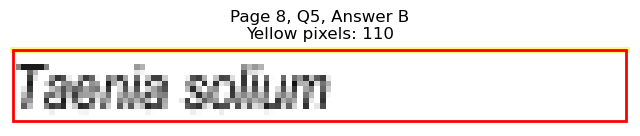

Page 8, Q5 - C: Detected box: x0=327.5, y0=341.9, x1=412.3, y1=354.6
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 423
Page 8, Q5, C: Yellow percentage: 0.0%


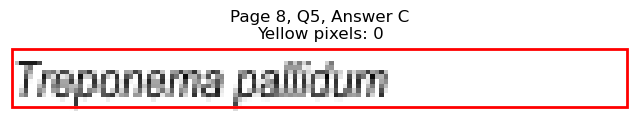

Page 8, Q5 - D: Detected box: x0=327.5, y0=354.5, x1=428.3, y1=367.2
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 528
Page 8, Q5, D: Yellow percentage: 0.0%


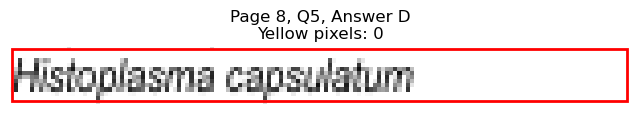


Page 8, Q5 - Selected Answer: A (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=392.3, x1=118.5, y1=405.0
Page 8, Q6, A: Yellow pixels: 1083
Page 8, Q6, A: Total non-white pixels: 1313
Page 8, Q6, A: Yellow percentage: 82.5%


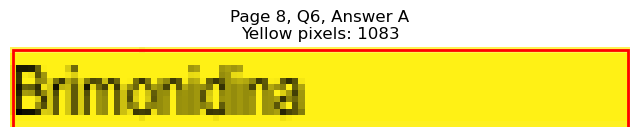

Page 8, Q6 - B: Detected box: x0=68.3, y0=404.9, x1=121.5, y1=417.6
Page 8, Q6, B: Yellow pixels: 104
Page 8, Q6, B: Total non-white pixels: 369
Page 8, Q6, B: Yellow percentage: 28.2%


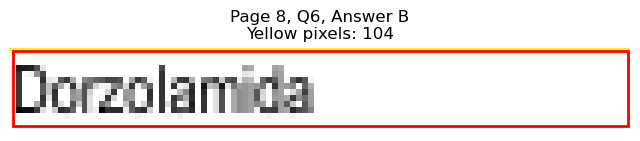

Page 8, Q6 - C: Detected box: x0=327.5, y0=392.3, x1=377.7, y1=405.0
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 249
Page 8, Q6, C: Yellow percentage: 0.0%


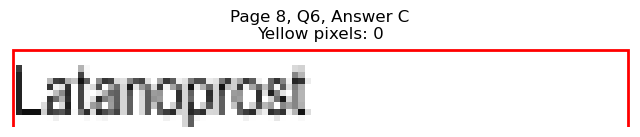

Page 8, Q6 - D: Detected box: x0=327.5, y0=404.9, x1=359.1, y1=417.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 157
Page 8, Q6, D: Yellow percentage: 0.0%


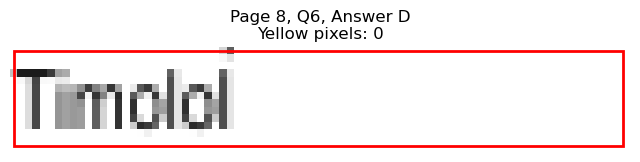


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=442.8, x1=181.7, y1=455.5
Page 8, Q7, A: Yellow pixels: 164
Page 8, Q7, A: Total non-white pixels: 745
Page 8, Q7, A: Yellow percentage: 22.0%


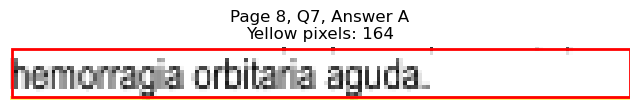

Page 8, Q7 - B: Detected box: x0=68.3, y0=455.5, x1=173.7, y1=468.1
Page 8, Q7, B: Yellow pixels: 1619
Page 8, Q7, B: Total non-white pixels: 2184
Page 8, Q7, B: Yellow percentage: 74.1%


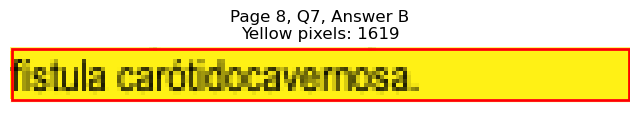

Page 8, Q7 - C: Detected box: x0=327.5, y0=442.8, x1=452.5, y1=455.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 611
Page 8, Q7, C: Yellow percentage: 0.0%


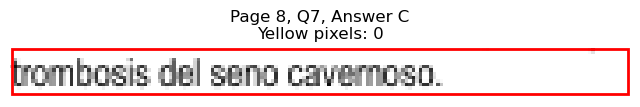

Page 8, Q7 - D: Detected box: x0=327.5, y0=455.5, x1=430.9, y1=468.1
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 539
Page 8, Q7, D: Yellow percentage: 0.0%


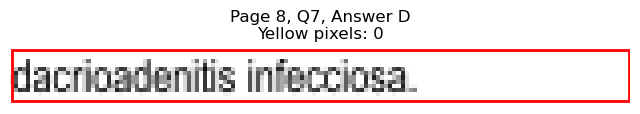


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=531.2, x1=122.4, y1=543.8
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 286
Page 8, Q8, A: Yellow percentage: 0.0%


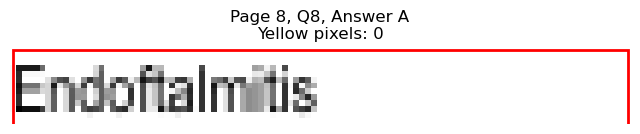

Page 8, Q8 - B: Detected box: x0=68.3, y0=543.8, x1=139.6, y1=556.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 357
Page 8, Q8, B: Yellow percentage: 0.0%


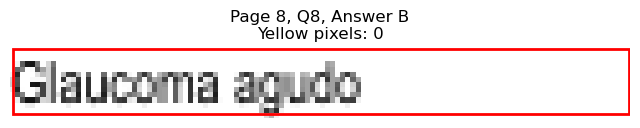

Page 8, Q8 - C: Detected box: x0=327.5, y0=531.2, x1=371.7, y1=543.8
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 341
Page 8, Q8, C: Yellow percentage: 0.0%


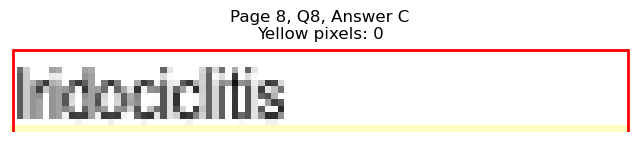

Page 8, Q8 - D: Detected box: x0=327.5, y0=543.8, x1=403.7, y1=556.4
Page 8, Q8, D: Yellow pixels: 1334
Page 8, Q8, D: Total non-white pixels: 1778
Page 8, Q8, D: Yellow percentage: 75.0%


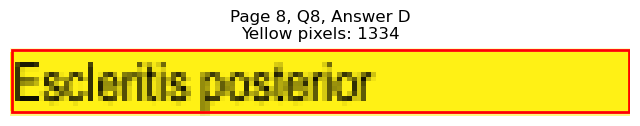


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=606.9, x1=103.5, y1=619.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 183
Page 8, Q9, A: Yellow percentage: 0.0%


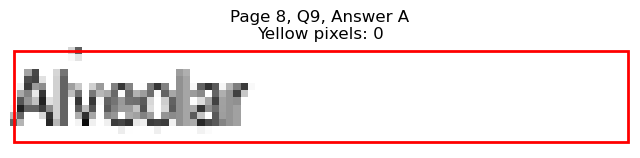

Page 8, Q9 - B: Detected box: x0=68.3, y0=619.6, x1=119.4, y1=632.3
Page 8, Q9, B: Yellow pixels: 1010
Page 8, Q9, B: Total non-white pixels: 1428
Page 8, Q9, B: Yellow percentage: 70.7%


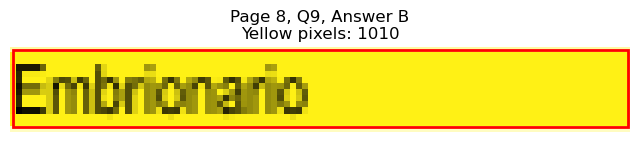

Page 8, Q9 - C: Detected box: x0=327.5, y0=606.9, x1=371.2, y1=619.6
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 205
Page 8, Q9, C: Yellow percentage: 0.0%


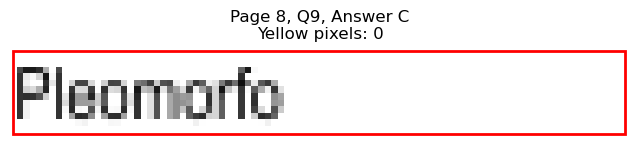

Page 8, Q9 - D: Detected box: x0=327.5, y0=619.6, x1=365.7, y1=632.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 213
Page 8, Q9, D: Yellow percentage: 0.0%


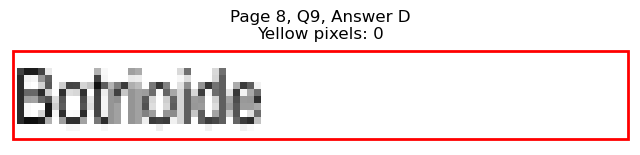


Page 8, Q9 - Selected Answer: B (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=670.1, x1=296.9, y1=682.7
Page 8, Q10, A: Yellow pixels: 2666
Page 8, Q10, A: Total non-white pixels: 3627
Page 8, Q10, A: Yellow percentage: 73.5%


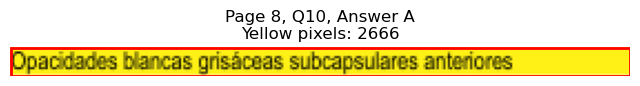

Page 8, Q10 - B: Detected box: x0=68.3, y0=682.7, x1=282.4, y1=695.3
Page 8, Q10, B: Yellow pixels: 263
Page 8, Q10, B: Total non-white pixels: 1356
Page 8, Q10, B: Yellow percentage: 19.4%


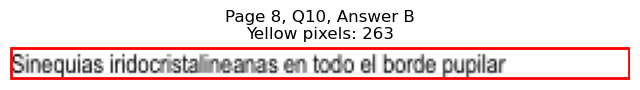

Page 8, Q10 - C: Detected box: x0=68.8, y0=695.4, x1=294.9, y1=708.0
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 1107
Page 8, Q10, C: Yellow percentage: 0.0%


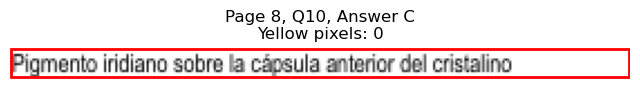

Page 8, Q10 - D: Detected box: x0=68.8, y0=708.0, x1=293.4, y1=720.6
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 1156
Page 8, Q10, D: Yellow percentage: 0.0%


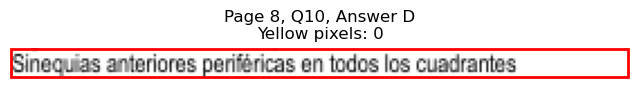


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=65.2, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 69
Page 9, Q1, A: Yellow percentage: 0.0%


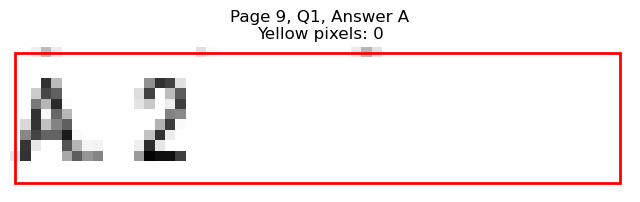

Page 9, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=65.2, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 60
Page 9, Q1, B: Yellow percentage: 0.0%


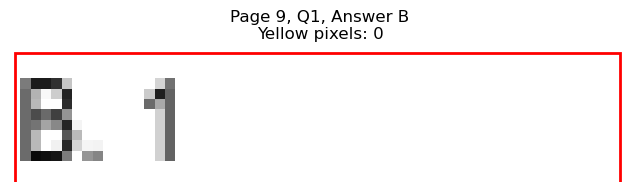

Page 9, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=324.4, y1=127.3
Page 9, Q1, C: Yellow pixels: 60
Page 9, Q1, C: Total non-white pixels: 125
Page 9, Q1, C: Yellow percentage: 48.0%


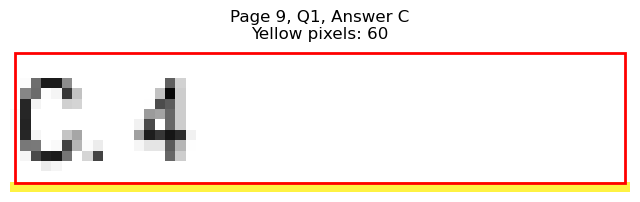

Page 9, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=324.4, y1=139.9
Page 9, Q1, D: Yellow pixels: 731
Page 9, Q1, D: Total non-white pixels: 780
Page 9, Q1, D: Yellow percentage: 93.7%


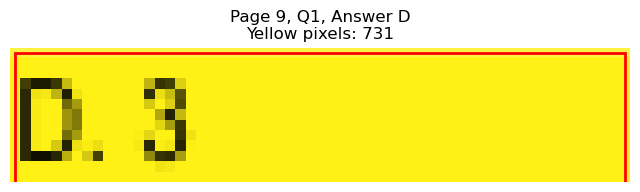


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=106.5, y1=177.8
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 192
Page 9, Q2, A: Yellow percentage: 0.0%


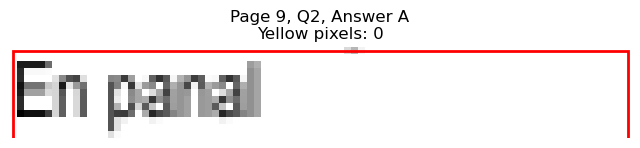

Page 9, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=143.5, y1=190.4
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 381
Page 9, Q2, B: Yellow percentage: 0.0%


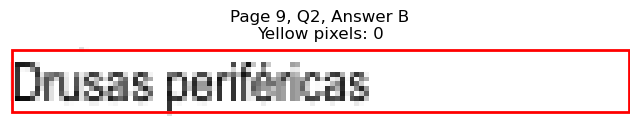

Page 9, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=389.7, y1=177.8
Page 9, Q2, C: Yellow pixels: 1231
Page 9, Q2, C: Total non-white pixels: 1469
Page 9, Q2, C: Yellow percentage: 83.8%


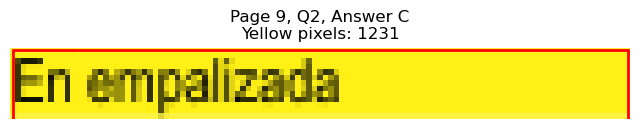

Page 9, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=382.3, y1=190.4
Page 9, Q2, D: Yellow pixels: 106
Page 9, Q2, D: Total non-white pixels: 389
Page 9, Q2, D: Yellow percentage: 27.2%


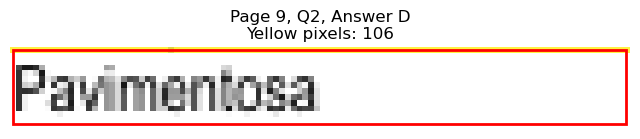


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=215.7, x1=278.0, y1=228.3
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 1089
Page 9, Q3, A: Yellow percentage: 0.0%


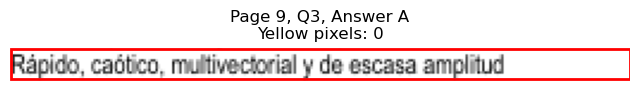

Page 9, Q3 - B: Detected box: x0=68.3, y0=228.3, x1=270.4, y1=240.9
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 1259
Page 9, Q3, B: Yellow percentage: 0.0%


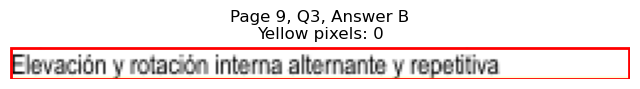

Page 9, Q3 - C: Detected box: x0=68.8, y0=240.9, x1=254.0, y1=253.5
Page 9, Q3, C: Yellow pixels: 2345
Page 9, Q3, C: Total non-white pixels: 3304
Page 9, Q3, C: Yellow percentage: 71.0%


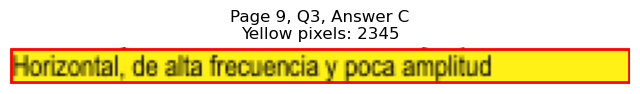

Page 9, Q3 - D: Detected box: x0=68.8, y0=253.5, x1=292.0, y1=266.1
Page 9, Q3, D: Yellow pixels: 275
Page 9, Q3, D: Total non-white pixels: 1355
Page 9, Q3, D: Yellow percentage: 20.3%


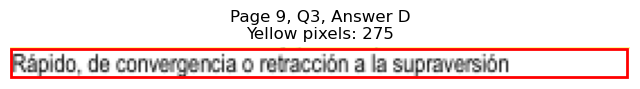


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=185.2, y1=316.7
Page 9, Q4, A: Yellow pixels: 1
Page 9, Q4, A: Total non-white pixels: 758
Page 9, Q4, A: Yellow percentage: 0.1%


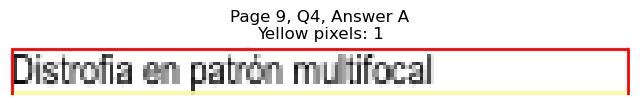

Page 9, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=172.1, y1=329.3
Page 9, Q4, B: Yellow pixels: 1429
Page 9, Q4, B: Total non-white pixels: 2170
Page 9, Q4, B: Yellow percentage: 65.9%


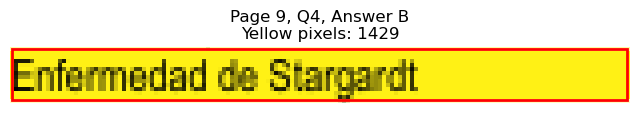

Page 9, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=412.3, y1=316.7
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 423
Page 9, Q4, C: Yellow percentage: 0.0%


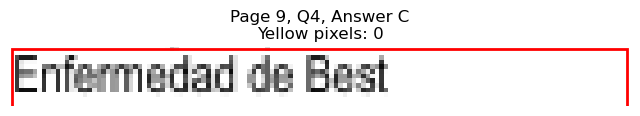

Page 9, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=450.4, y1=329.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 635
Page 9, Q4, D: Yellow percentage: 0.0%


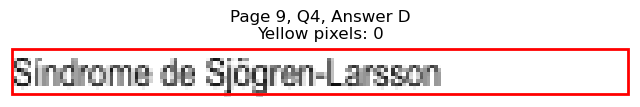


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=93.9, y1=367.2
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 138
Page 9, Q5, A: Yellow percentage: 0.0%


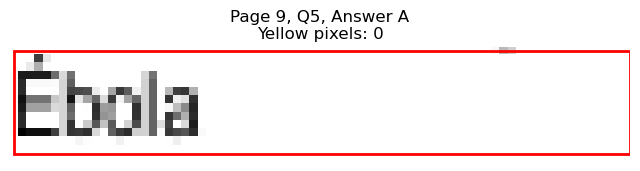

Page 9, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=123.5, y1=379.8
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 257
Page 9, Q5, B: Yellow percentage: 0.0%


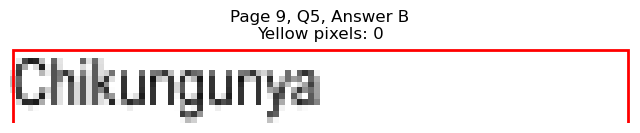

Page 9, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=359.1, y1=367.2
Page 9, Q5, C: Yellow pixels: 940
Page 9, Q5, C: Total non-white pixels: 1162
Page 9, Q5, C: Yellow percentage: 80.9%


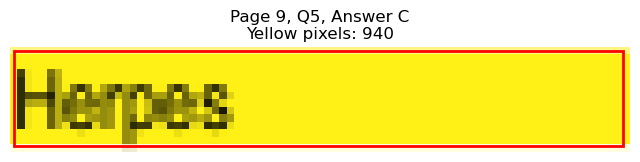

Page 9, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=361.6, y1=379.8
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 269
Page 9, Q5, D: Yellow percentage: 0.0%


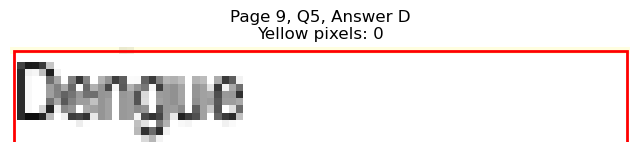


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=275.4, y1=430.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 1070
Page 9, Q6, A: Yellow percentage: 0.0%


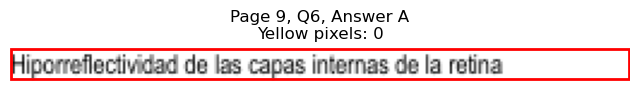

Page 9, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=167.1, y1=442.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 623
Page 9, Q6, B: Yellow percentage: 0.0%


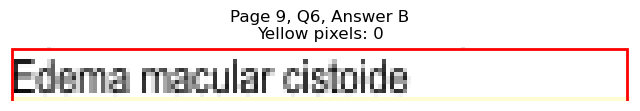

Page 9, Q6 - C: Detected box: x0=68.8, y0=442.8, x1=278.4, y1=455.5
Page 9, Q6, C: Yellow pixels: 2594
Page 9, Q6, C: Total non-white pixels: 3654
Page 9, Q6, C: Yellow percentage: 71.0%


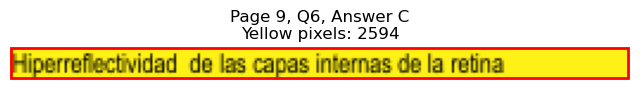

Page 9, Q6 - D: Detected box: x0=68.8, y0=455.5, x1=144.0, y1=468.1
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 386
Page 9, Q6, D: Yellow percentage: 0.0%


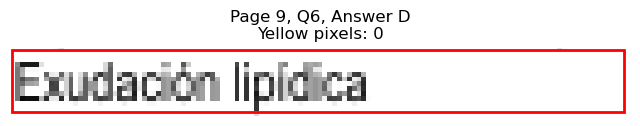


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=109.5, y1=518.6
Page 9, Q7, A: Yellow pixels: 1047
Page 9, Q7, A: Total non-white pixels: 1288
Page 9, Q7, A: Yellow percentage: 81.3%


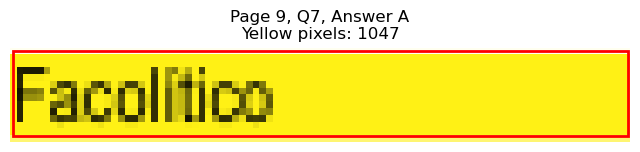

Page 9, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=136.0, y1=531.2
Page 9, Q7, B: Yellow pixels: 118
Page 9, Q7, B: Total non-white pixels: 468
Page 9, Q7, B: Yellow percentage: 25.2%


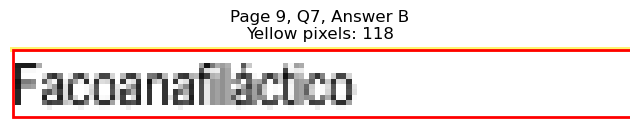

Page 9, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=379.7, y1=518.6
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 252
Page 9, Q7, C: Yellow percentage: 0.0%


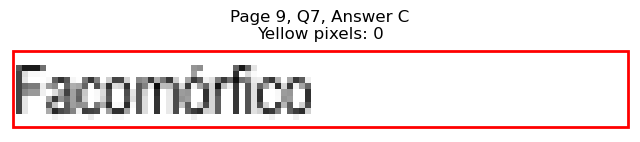

Page 9, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=373.7, y1=531.2
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 233
Page 9, Q7, D: Yellow percentage: 0.0%


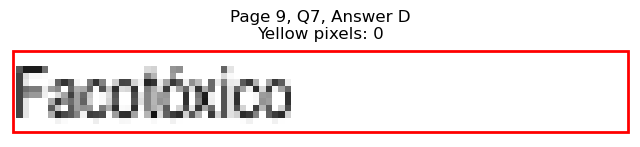


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=556.5, x1=197.2, y1=569.2
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 638
Page 9, Q8, A: Yellow percentage: 0.0%


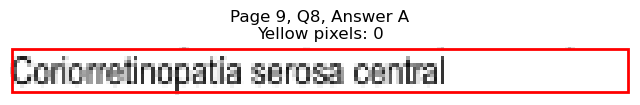

Page 9, Q8 - B: Detected box: x0=68.3, y0=569.1, x1=176.2, y1=581.8
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 544
Page 9, Q8, B: Yellow percentage: 0.0%


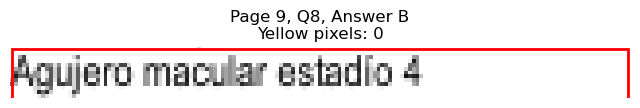

Page 9, Q8 - C: Detected box: x0=327.5, y0=556.5, x1=424.9, y1=569.2
Page 9, Q8, C: Yellow pixels: 1556
Page 9, Q8, C: Total non-white pixels: 2072
Page 9, Q8, C: Yellow percentage: 75.1%


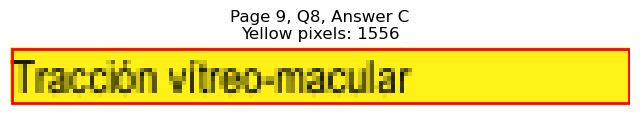

Page 9, Q8 - D: Detected box: x0=327.5, y0=569.1, x1=431.8, y1=581.8
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 680
Page 9, Q8, D: Yellow percentage: 0.0%


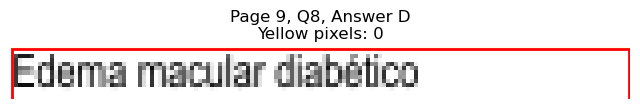


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=670.1, x1=197.8, y1=682.7
Page 9, Q9, A: Yellow pixels: 2
Page 9, Q9, A: Total non-white pixels: 868
Page 9, Q9, A: Yellow percentage: 0.2%


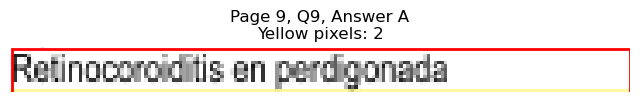

Page 9, Q9 - B: Detected box: x0=68.3, y0=682.7, x1=227.8, y1=695.3
Page 9, Q9, B: Yellow pixels: 1895
Page 9, Q9, B: Total non-white pixels: 2940
Page 9, Q9, B: Yellow percentage: 64.5%


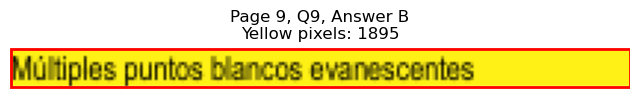

Page 9, Q9 - C: Detected box: x0=327.5, y0=670.1, x1=452.0, y1=682.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 650
Page 9, Q9, C: Yellow percentage: 0.0%


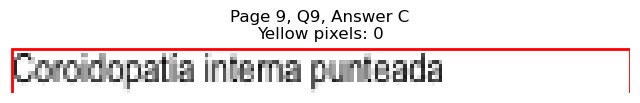

Page 9, Q9 - D: Detected box: x0=327.5, y0=682.7, x1=503.6, y1=695.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 903
Page 9, Q9, D: Yellow percentage: 0.0%


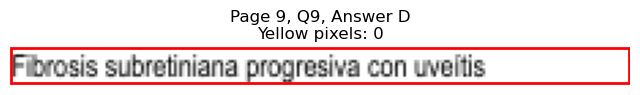


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=733.2, x1=181.1, y1=745.8
Page 9, Q10, A: Yellow pixels: 1700
Page 9, Q10, A: Total non-white pixels: 2132
Page 9, Q10, A: Yellow percentage: 79.7%


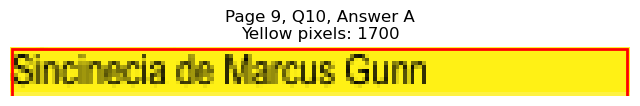

Page 9, Q10 - B: Detected box: x0=68.3, y0=745.8, x1=267.5, y1=758.4
Page 9, Q10, B: Yellow pixels: 213
Page 9, Q10, B: Total non-white pixels: 1234
Page 9, Q10, B: Yellow percentage: 17.3%


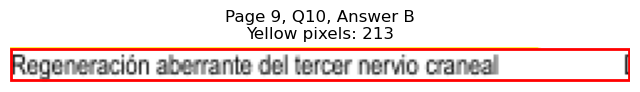

Page 9, Q10 - C: Detected box: x0=327.5, y0=733.2, x1=411.8, y1=745.8
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 420
Page 9, Q10, C: Yellow percentage: 0.0%


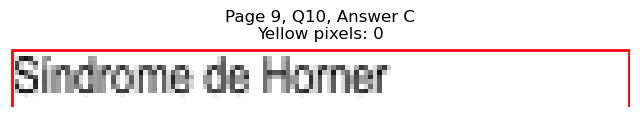

Page 9, Q10 - D: Detected box: x0=327.5, y0=745.8, x1=449.9, y1=758.4
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 604
Page 9, Q10, D: Yellow percentage: 0.0%


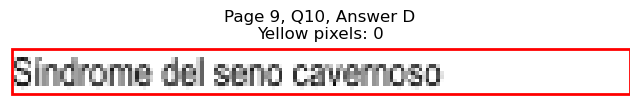


Page 9, Q10 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 3 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=94.8, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 210
Page 10, Q1, A: Yellow percentage: 0.0%


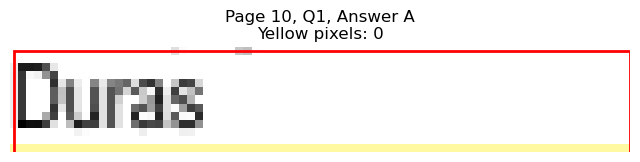

Page 10, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=109.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 916
Page 10, Q1, B: Total non-white pixels: 1288
Page 10, Q1, B: Yellow percentage: 71.1%


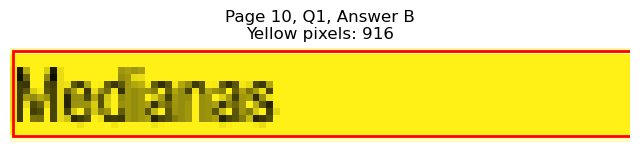

Page 10, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=362.7, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 164
Page 10, Q1, C: Yellow percentage: 0.0%


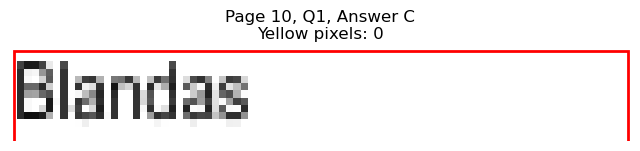

Page 10, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=375.2, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 249
Page 10, Q1, D: Yellow percentage: 0.0%


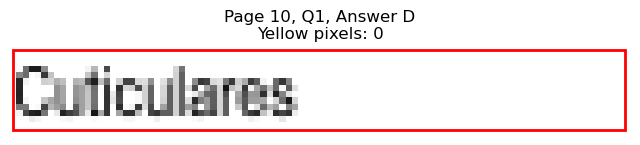


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=188.7, y1=165.2
Page 10, Q2, A: Yellow pixels: 171
Page 10, Q2, A: Total non-white pixels: 733
Page 10, Q2, A: Yellow percentage: 23.3%


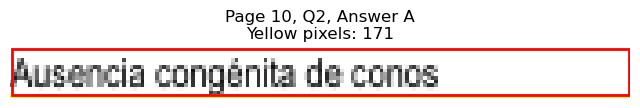

Page 10, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=139.6, y1=177.8
Page 10, Q2, B: Yellow pixels: 1287
Page 10, Q2, B: Total non-white pixels: 1586
Page 10, Q2, B: Yellow percentage: 81.1%


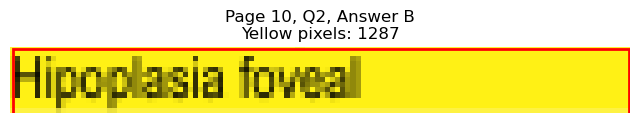

Page 10, Q2 - C: Detected box: x0=327.5, y0=152.5, x1=440.3, y1=165.2
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 582
Page 10, Q2, C: Yellow percentage: 0.0%


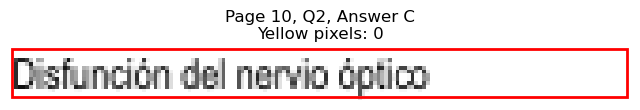

Page 10, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=403.7, y1=177.8
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 418
Page 10, Q2, D: Yellow percentage: 0.0%


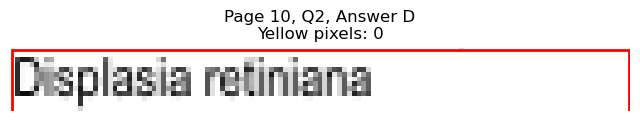


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=202.9, x1=197.2, y1=215.6
Page 10, Q3, A: Yellow pixels: 1828
Page 10, Q3, A: Total non-white pixels: 2520
Page 10, Q3, A: Yellow percentage: 72.5%


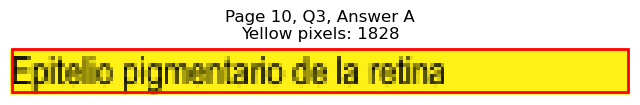

Page 10, Q3 - B: Detected box: x0=68.3, y0=215.7, x1=152.5, y1=228.3
Page 10, Q3, B: Yellow pixels: 133
Page 10, Q3, B: Total non-white pixels: 537
Page 10, Q3, B: Yellow percentage: 24.8%


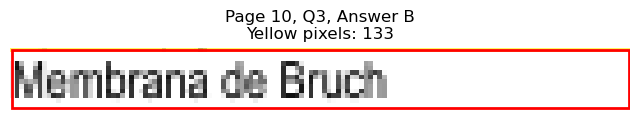

Page 10, Q3 - C: Detected box: x0=327.5, y0=202.9, x1=384.7, y1=215.6
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 310
Page 10, Q3, C: Yellow percentage: 0.0%


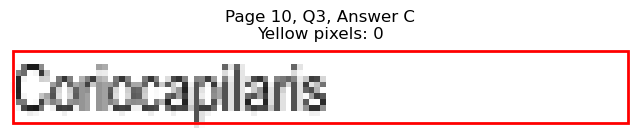

Page 10, Q3 - D: Detected box: x0=327.5, y0=215.7, x1=467.5, y1=228.3
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 678
Page 10, Q3, D: Yellow percentage: 0.0%


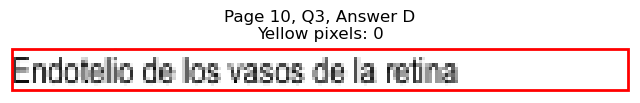


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 24 años con hepatopatía inespecífica,...
1   ¿Cuál de los siguientes quistes es un hidrocis...
2   Mujer de 70 años, PO3 de catarata. Examen: len...
3   ¿Cuál es el patrón de herencia de la neuropatí...
4   Varón de 18 años con hipoacusia neurosensorial...
..                                                ...
95  Mujer de 28 años acudió por disminución súbita...
96  ¿En qué patología se produce la retracción del...
97  ¿Cuál de los siguientes tipos de drusas se def...
98  ¿Cuál es la causa de la disminución de la visi...
99  ¿Cuál se considera barrera hematorretiniana ex...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                     α1- antitripsina   
1                              De Zeis   
2        Análogos de la prostaglandina   
3   De mutaciones del ADN mitocondrial   
4                    Luxación superior   
..                                 ...   
95     Retinocoroiditis en perdigonada   
96           Sincinecia de Marcus Gunn   
97                               Duras   
98         Ausencia congénita de conos   
99   Epitelio pigmentario de la retina   

                                            option_B  \
0                                     Ceruloplasmina   
1                                            De Moll   
2                     Betabloqueadores no selectivos   
3                   Ligado a cromosoma X (dominante)   
4                     Catarata “en árbol de navidad”   
..                                               ...   
95             Múltiples puntos blancos evanescentes   
96  Regeneración aberrante del tercer nervio craneal   
97                                          Medianas   
98                                 Hipoplasia foveal   
99                                 Membrana de Bruch   

                                 option_C  \
0                               Ferritina   
1                                  Miliar   
2   Inhibidores de la anhidrasa carbónica   
3               Por mutación del gen PAX6   
4            Catarata “en gota de aceite”   
..                                    ...   
95          Coroidopatía interna punteada   
96                     Síndrome de Horner   
97                                Blandas   
98           Disfunción del nervio óptico   
99                         Coriocapilaris   

                                        option_D  
0                                        Tiamina  
1                                       Dermoide  
2                 Agentes parasimpaticomiméticos  
3                Ligado a cromosoma X (recesivo)  
4                             Lenticono anterior  
..                                           ...  
95  Fibrosis subretiniana progresiva con uveítis  
96                   Síndrome del seno cavernoso  
97                                   Cuticulares  
98                           Displasia retiniana  
99           Endotelio de los vasos de la retina  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 24 años con hepatopatía inespecífica,...   
1   ¿Cuál de los siguientes quistes es un hidrocis...   
2   Mujer de 70 años, PO3 de catarata. Examen: len...   
3   ¿Cuál es el patrón de herencia de la neuropatí...   
4   Varón de 18 años con hipoacusia neurosensorial...   
..                                                ...   
95  Mujer de 28 años acudió por disminución súbita...   
96  ¿En qué patología se produce la retracción del...   
97  ¿Cuál de los siguientes tipos de drusas se def...   
98  ¿Cuál es la causa de la disminución de la visi...   
99  ¿Cuál se considera barrera hematorretiniana ex...   

                              option_A  \
0                     α1- antitripsina   
1                              De Zeis   
2        Análogos de la prostaglandina   
3   De mutaciones del ADN mitocondrial   
4                    Luxación superior   
..                                 ...   
95     Retinocoroiditis en perdigonada   
96           Sincinecia de Marcus Gunn   
97                               Duras   
98         Ausencia congénita de conos   
99   Epitelio pigmentario de la retina   

                                            option_B  \
0                                     Ceruloplasmina   
1                                            De Moll   
2                     Betabloqueadores no selectivos   
3                   Ligado a cromosoma X (dominante)   
4                     Catarata “en árbol de navidad”   
..                                               ...   
95             Múltiples puntos blancos evanescentes   
96  Regeneración aberrante del tercer nervio craneal   
97                                          Medianas   
98                                 Hipoplasia foveal   
99                                 Membrana de Bruch   

                                 option_C  \
0                               Ferritina   
1                                  Miliar   
2   Inhibidores de la anhidrasa carbónica   
3               Por mutación del gen PAX6   
4            Catarata “en gota de aceite”   
..                                    ...   
95          Coroidopatía interna punteada   
96                     Síndrome de Horner   
97                                Blandas   
98           Disfunción del nervio óptico   
99                         Coriocapilaris   

                                        option_D correct_answer  
0                                        Tiamina              B  
1                                       Dermoide              B  
2                 Agentes parasimpaticomiméticos              A  
3                Ligado a cromosoma X (recesivo)              A  
4                             Lenticono anterior              D  
..                                           ...            ...  
95  Fibrosis subretiniana progresiva con uveítis              B  
96                   Síndrome del seno cavernoso              A  
97                                   Cuticulares              B  
98                           Displasia retiniana              B  
99           Endotelio de los vasos de la retina              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/OFTALMOLOGÍA.csv
